# CYBER Master

This project is to process the data of recorded voices and baseline measurements for the attachment style interaction with depression and anxiety, in a sense this will work a the ETL or pre-processing of the data.

This notebook has a single purpose expressed in the following steps:
- Gather the answers from the survey DB
- Process the answers by uniques and present a report of the demographics, attachment styles and HADS answers
- From each answer, get the recordings from blob storage.
- For each recording transcribe them and associate them to the answer
- Store the resulting data in the DB for further analysis

In [1]:
# -*- coding: utf-8 -*-

# Import the necessary libraries
import os
import json
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
import subprocess
import requests
from typing import List, Tuple, Optional
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv(find_dotenv())

CONSENT_SURVEY_ID = "8"
STUDY_SURVEY_ID = "7"
OLLAMA_VERSION = "v0.12"

QUESTIONS = {
    "en": {
        "1": "What’s happening in the picture?",
        "2": "What led up to that scene?",
        "3": "What the characters are thinking or feeling?",
        "4": "What might happen next?",
    },
    "es": {
        "1": "¿Qué está pasando en la imagen?",
        "2": "¿Qué eventos llevaron a esta escena?",
        "3": "¿Qué están sintiendo o pensando los personajes?",
        "4": "¿Qué ocurrirá a continuación?",
    },
}

IMAGE_KEYS = [
    "Image 1 - 1",
    "Image 1 - 2",
    "Image 1 - 3",
    "Image 1 - 4",
    "Image 2 - 1",
    "Image 2 - 2",
    "Image 2 - 3",
    "Image 2 - 4",
    "Image 3 - 1",
    "Image 3 - 2",
    "Image 3 - 3",
    "Image 3 - 4",
    "Image 4 - 1",
    "Image 4 - 2",
    "Image 4 - 3",
    "Image 4 - 4",
    "Image 5 -1",
    "Image 5 - 2",
    "Image 5 - 3",
    "Image 5 - 4",
    "Image 6 - 1",
    "Image 6 - 2",
    "Image 6 - 3",
    "Image 6 - 4",
    "Image 7 - 1",
    "Image 7 - 2",
    "Image 7 - 3",
    "Image 7 - 4",
    "Image 8 - 1",
    "Image 8 - 2",
    "Image 8 - 3",
    "Image 8 - 4",
]


def transcribe_audio(file_path, language="en"):
    # Use the local vosk via CLI to get the transcription
    result_file = file_path.replace(".wav", ".txt")
    subprocess.run(
        [
            "vosk-transcriber",
            "-i",
            file_path,
            "-l",
            language,
            "-o",
            result_file,
            "--log-level",
            "INFO",
        ]
    )
    # Read the transcription
    with open(result_file, "r") as transcription_file:
        transcription = transcription_file.read()
        return transcription


def request_llm_analysis(prompts: List[str], language="en"):
    url = "http://localhost:11434/api/generate"
    prompt = (
        "No explanations or additional information should be included in the answer only the results, Consider only the following information."
        + " answer only in one line, do not include any additional information or context, answer in the format:"
        + " 'Attachment style: [secure|insecure], Anxiety: [], Depression: []'"
        + " treat each prompt as if it comes from a person with a different attachment style, anxiety, and depression levels."
    )
    prompt += " ".join(prompts)
    data = {
        "prompt": prompt,
        "model": OLLAMA_VERSION,
    }
    response = requests.post(url, json=data)
    result = ""
    for line in response.text.split("\n"):
        if '"done": true' in line or not line:
            return result
        else:
            try:
                result += json.loads(line)["response"]
            except Exception as e:
                print(e)
                print(line)
                continue

    return result


def score_HADS(answers: dict) -> tuple:
    anxiety_items = {
        "HADS 1": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 5": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 6": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 8": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 9": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 12": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 13": {"0": 3, "1": 2, "2": 1, "3": 0},
    }
    depression_items = {
        "HADS 2": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 3": {"0": 0, "1": 1, "2": 2, "3": 3},
        "HADS 4": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 7": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 10": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 11": {"0": 3, "1": 2, "2": 1, "3": 0},
        "HADS 14": {"0": 0, "1": 1, "2": 2, "3": 3},
    }

    anxiety_score = 0
    depression_score = 0

    for item, answer in answers.items():
        if item in anxiety_items:
            anxiety_score += anxiety_items[item][answer]
        elif item in depression_items:
            depression_score += depression_items[item][answer]

    return anxiety_score, depression_score


def score_RQ(answers: dict) -> dict:
    anxiety_score = 0
    avoidance_score = 0

    styles = {
        "A": "Secure",
        "B": "Fearful",
        "C": "Preoccupied",
        "D": "Dismissing",
    }

    results = {}
    for item, answer in answers.items():
        if item == "RQ1":
            results["style"] = styles[answer]
        elif item == "RQ2":
            anxiety_score += int(answer)
            avoidance_score += int(answer)
        elif item == "RQ3":
            anxiety_score -= int(answer)
            avoidance_score -= int(answer)
        elif item == "RQ4":
            anxiety_score -= int(answer)
            avoidance_score += int(answer)
        elif item == "RQ5":
            anxiety_score += int(answer)
            avoidance_score -= int(answer)

    results["anxiety"] = anxiety_score
    results["avoidance"] = avoidance_score
    return results


def get_only_numbers(text: str) -> str:
    return "".join(filter(str.isdigit, text))


def get_styles_percentage(
    styles: list, percentages: bool = False
) -> Tuple[str, Optional[dict]]:
    result = {}
    total = len(styles)
    for style in styles:
        if style not in result:
            result[style] = styles.count(style)
    style = max(result, key=result.get)
    if percentages:
        return style, {key: value / total for key, value in result.items()}
    return style


def get_scores_average(scores: list[int]) -> float:
    if len(scores) == 0:
        return 0
    return sum(scores) / len(scores)


now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")

## Connect to the DB

In [2]:
import mysql.connector

connection = mysql.connector.connect(
    user=os.getenv("DB_USERNAME"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    port=os.getenv("DB_PORT"),
)
cursor = connection.cursor()

# query the answers table
query = (
    f"SELECT * FROM surveys_answer where surveys_answer.survey_id = {STUDY_SURVEY_ID}"
)
cursor.execute(query)
answers = cursor.fetchall()

In [3]:
# Parse the answers
json_answers = []

for answer in answers:
    dict_answer = json.loads(json.loads(answer[1]))
    if dict_answer.get("response-uuid") not in [
        answer.get("response-uuid") for answer in json_answers
    ]:
        json_answers.append({"id": answer[0], **json.loads(json.loads(answer[1]))})
    else:
        for json_answer in json_answers:
            if json_answer.get("response-uuid") == dict_answer.get("response-uuid"):
                json_answer.update(json.loads(json.loads(answer[1])))
                break

full_answers = [answer for answer in json_answers if len(answer.keys()) >= 62]
# get answers by language in a dictionary
answers_by_language = {}
answers_by_language = {
    "en": len([answer for answer in full_answers if answer["language"] == "en"]),
    "es": len([answer for answer in full_answers if answer["language"] == "es"]),
    "pt": len([answer for answer in full_answers if answer["language"] == "pt"]),
}
print(answers_by_language)

{'en': 38, 'es': 12, 'pt': 0}


In [4]:
# Get the excluded answers
excluded_answers = []
for answer in json_answers:
    if "Demographic - speech diagnosis" not in answer.keys() or "Demographic - psychiatric disorder" not in answer.keys() or "Demographic - Substances" not in answer.keys():
        continue
    if answer["Demographic - speech diagnosis"] == "yes" or answer["Demographic - psychiatric disorder"] == "yes" or answer["Demographic - Substances"] == "yes":
        excluded_answers.append(answer)

print(len(excluded_answers))

58


In [7]:
# Get the recording info from the recording table
recordings_query = f"SELECT * FROM surveys_recording"  # where surveys_recording.answer_id in ({','.join([str(answer.get('id')) for answer in full_answers])})"
cursor.execute(recordings_query)
recordings = cursor.fetchall()

In [8]:
for answer in full_answers:
    for recording in recordings:
        for key, value in answer.items():
            if not isinstance(value, str) or len(value) < 4:
                continue
            if value.replace("-", "") != recording[-1]:
                continue
            answer[key] = f"{recording[1].replace('recordings/', '')}.wav"

## Getting the recordings per answer

In [9]:
from azure.storage.blob import BlobServiceClient

CONTAINER_NAME = "recordings"

blob_service = BlobServiceClient.from_connection_string(
    os.getenv("AZURE_CONNECTION_STRING")
)
local_path = "./recordings"
# create the folder if not alrady
if not os.path.exists(local_path):
    os.mkdir(local_path)

# Sanity check, listing the blobs in the container
container_client = blob_service.get_container_client(CONTAINER_NAME)
blob_list = []
for blob in container_client.list_blobs():
    if "blob" in blob.name:
        blob_list.append(blob.name)

In [10]:
# Download the blobs into the recordings folder if not already downloaded
for blob in blob_list:
    result_file_name = blob.split("/")[-1]
    result_file_name = f"{result_file_name}.wav"
    if result_file_name not in os.listdir(local_path):
        with open(file=f"{local_path}/{result_file_name}", mode="wb") as audio_file:
            download_stream = container_client.download_blob(blob)
            audio_file.write(download_stream.readall())

# list all the files in the folder
files = os.listdir(local_path)
print(len(files))

3280


## Vosk

We are using [vosk](https://alphacephei.com/vosk/) to transcribe the audio into text, then assign it to the answer for further processing

In [ ]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

In [9]:
for answer in full_answers:
    for key, value in answer.items():
        if not isinstance(value, str) or not value.endswith(".wav"):
            continue
        if value not in files:
            print(f"File {value} not found")
            continue
        if value.replace(".wav", ".txt") in os.listdir(local_path):
            print(f"File {value} already transcribed")
            answer[key] = open(
                f"{local_path}/{value.replace('.wav', '.txt')}", "r"
            ).read()
            continue
        answer[key] = transcribe_audio(
            f"{local_path}/{value}", language=answer["language"]
        )

## Scoring the validated scales

We are using the HADS and RQ scales to determine the anxiety and depression, and the attachment style status accordingly.

### HADS - Hospital Anxiety and Depression Scale
A self report tool developed in 1983 by [Zigmond and Snaith](https://pubmed.ncbi.nlm.nih.gov/6880820/). It allows a dimensional scoring of the status of the patient and allows the better understanding of the psychiatric and psychological needs of a hospital patient.

The scale is composed of 14 items in a 4-item likert scale pointed from 0 to 3 and dedicates 7 items to depression and anxiety respectively. The scoring occurs by aggregating the values of each item and group, therefore, distributed as follows:
- Scores 0 to 7: Normal
- Scores 8 to 10: Borderline abnormal (at risk(?))
- Scores 11 - 21:  Abnormal (Usually requires a proper diagnosis and treatment)


### RQ - The Relationship Questionnaire
A self report questionnaire developed in 1991 by [Bartholomew & Horowitz](https://pubmed.ncbi.nlm.nih.gov/1920064/) composed of two segments with the objective of measuring the adult attachment styles. the styles are defined on two axis: Avoidance and anxiety.
The avoidance axis refers to the internal model of others and the anxiety to the internal model of self and usually presented as a cartesian plane, in which an adult may have a combination of both axis.
The four general cartesian regions in the adult attachment are:
**Secure**: Low avoidance - Low anxiety: The person considers others and themselves as trustworthy.
**Preoccupied**: Low avoidance - High anxiety: The person considers others are more trustworthy and generate a dependency due to internal low self-worth.
**Dismissing**: High avoidance - Low anxiety: The person has low trust on others but is self-reliant (opossite to the one above).
**Fearful**: High avoidance - High anxiety: The person does not trust others and has low self worth.

In this scale a person will first select a paragraph that reflects directly one of the styles above, then rates the agreement with each style prototype in a 7-item likert scales. From the answers in the likert scales the values on both axis are extracted and calculated as follows:
- **Model of self**: (secure + dissmissing) - (preocupied + fearful)
- **Model of others**: (secure + preocupied) - (dissmissing + fearful)

In [10]:
# Score HADS and RQ from the full_answers
for answer in full_answers:
    answer["HADS score - Anxiety"], answer["HADS score - Depression"] = score_HADS(
        {f"HADS {i}": answer.get(f"HADS {i}") for i in range(1, 15)}
    )
    answer["RQ score"] = score_RQ({f"RQ{i}": answer.get(f"RQ{i}") for i in range(1, 6)})

## Invoquing OLlama model using the prompts

The audio tracks were transcribed and will be fed in a custom prompt to a local Llama2 model using the [OLlama framework](https://ollama.com/)([Git hub documentation](https://github.com/ollama/ollama)).

The model has been pretrained by setting the `seed`, to ensure more deterministic results, and with a preparation prompt with extra instructions. The model is asked to act as a psiquiatrist assistant and given some context about the attachment styles, following the best practices mentioned in the literature ([1](https://arxiv.org/abs/2309.09128), [2](https://www.jmir.org/2023/1/e50638/), [3](https://link.springer.com/chapter/10.1007/978-981-99-7962-2_30)) The prompts and settings used in setup are available in the file `Modelfile` in this repository.


Then for each participant we agreggate all answers to the images and ask the model to determine the attachment style and two percentages for anxiety and depression afterwards.

In [11]:
# prepare the prompt to be fed to the LLM
for answer in full_answers:
    answer["prompts"] = []
    for key in IMAGE_KEYS:
        if answer.get(key) is None:
            continue
        answer.get("prompts").append(
            f"{key[0:8]} - {QUESTIONS.get(answer.get('language')).get(key[-1])} {answer[key]}"
        )

In [ ]:
# request the LLM analysis

for answer in full_answers:
    answer["llm"] = []
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    for prompt in answer.get("prompts"):
        llm_answer = request_llm_analysis([prompt], language=answer.get("language"))
        answer.get("llm").append(llm_answer)
        # find the attachment style, anxiety and depression scores by getting the index of the prompt
        llm_answer = llm_answer.lower()
        print(llm_answer)
        # If the model has low allucination and answers in the instructed format, thiscan be used to format the answer
        # for aux_answer in llm_answer.split(","):
        #     split_ans = aux_answer.split()
        #     if "attachment style" in aux_answer:
        #         style_name = "insecure" if "insecure" in aux_answer else "secure"
        #         answer.get("llm_attachment_style").append(style_name)
        #     if "anxiety:" in aux_answer:
        #         index = split_ans.index("anxiety:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     elif "anxiety" in aux_answer:
        #         index = split_ans.index("anxiety")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_anxiety").append(score)
        #     else:
        #         answer.get("llm_anxiety").append(None)
        #     if "depression:" in aux_answer:
        #         index = split_ans.index("depression:")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     elif "depression" in aux_answer:
        #         index = split_ans.index("depression")
        #         score = get_only_numbers(split_ans[index + 1])
        #         answer.get("llm_depression").append(score)
        #     else:
        #         answer.get("llm_depression").append(None)

## Store the resulting data

In [59]:
# save the answers in a json lines file
with open(f"raw_answers-{now_date}.json", "w") as answers_file:
    answers_file.write(json.dumps(full_answers, indent=4))

print(len(full_answers))

50


## Final data preparation

***Note:*** Due to LLM allucination and result rendering, the data has a manual segment under the key `curated_llm` which is a cleanup of the data in `llm` (the original answer from the model) keeping exclusively the first segment of the answer holding the relevant data., this is subjected to the data separation mentioned in this section.


In order to compare the results from RQ, HADS and the LLM data we need to transform the data from the LLM:
* __Attachment style:__ We want to report a percentage of each style to present from the amount of times one style is mentioned in the list.
* __Anxiety and Depression:__ An average value from the reported values may allow to compare to HADS.

We want to address two specific questions:
- Which image has more accurate information about attachment, anxiety, and depression.
- Which question (1, 2, 3, 4) in all images is more accurate as well.

In order to answer those questions the data should be grouped per image and per question to gather the average and compare

In [60]:
# Load the answers from the json lines file
# This allows to continue the processing after manual cleaning and allows to not run the model again
with open(f"raw_answers-2024-05-31--09-34.json", "r") as answers_file:
    full_answers = json.load(answers_file)

print(len(full_answers))

50


In [61]:
# Split the information of attachment style, anxiety and depression scores
for answer in full_answers:
    answer["llm_attachment_style"] = []
    answer["llm_anxiety"] = []
    answer["llm_depression"] = []
    try:
        for llm_data in answer.get("llm"):
            lower_llm_data = llm_data.lower()
            split_ans = lower_llm_data.lower().split()
            if "attachment style" in lower_llm_data:
                style_name = "insecure" if "insecure" in lower_llm_data else "secure"
                answer.get("llm_attachment_style").append(style_name)

            if "anxiety:" in lower_llm_data:
                index = split_ans.index("anxiety:")
                score = get_only_numbers(split_ans[index + 1])
                answer.get("llm_anxiety").append(score)

            if "depression:" in lower_llm_data:
                index = split_ans.index("depression:")
                try:
                    score = get_only_numbers(split_ans[index + 1])
                except Exception as e:
                    print(e)
                    print(split_ans)
                    print(answer)
                    continue
                answer.get("llm_depression").append(score)
    except Exception as e:
        print(e)
        print(split_ans)
        print(answer)
        continue

In [62]:
for answer in full_answers:
    # get the llm_attachment_style, llm_anxiety, llm_depression
    llm_attachment_style = answer.get("llm_attachment_style")
    llm_anxiety = answer.get("llm_anxiety")
    llm_depression = answer.get("llm_depression")
    if not llm_attachment_style:
        print(answer)
        continue
    # calculate the average of the llm_anxiety and llm_depression
    anxiety_aux = [int(i) for i in llm_anxiety if i is not None]
    llm_anxiety_average = (
        sum(anxiety_aux) / len(anxiety_aux) if len(anxiety_aux) > 0 else None
    )
    depression_aux = [int(i) for i in llm_depression if i is not None]
    llm_depression_average = (
        sum(depression_aux) / len(depression_aux) if len(depression_aux) > 0 else None
    )
    answer["llm_anxiety_average"] = llm_anxiety_average
    answer["llm_depression_average"] = llm_depression_average
    # get the amount of times the attachment style was mentioned
    answer["llm_attachment_styles_percentages"] = get_styles_percentage(
        llm_attachment_style
    )

Split the answers by Image:

In [63]:
for answer in full_answers:
    for img_num in range(1, 9):
        answer[f"image_{img_num}_llm_style"] = get_styles_percentage(
            answer.get("llm_attachment_style")[img_num - 1 : img_num + 3]
        )
        answer[f"image_{img_num}_llm_anxiety"] = get_scores_average(
            [
                int(_)
                for _ in answer.get("llm_anxiety")[img_num - 1 : img_num + 3]
                if _ is not None
            ]
        )
        answer[f"image_{img_num}_llm_depression"] = get_scores_average(
            [
                int(_)
                for _ in answer.get("llm_depression")[img_num - 1 : img_num + 3]
                if _ is not None
            ]
        )

Split the answers by question: Description, Past, Present, Future

In [64]:
description_index = [0, 4, 8, 12, 16, 20, 24, 28]
past_index = [1, 5, 9, 13, 17, 21, 25, 29]
present_index = [2, 6, 10, 14, 18, 22, 26, 30]
future_index = [3, 7, 11, 15, 19, 23, 27, 31]

for answer in full_answers:
    answer["description_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in description_index]
    )
    answer["description_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in description_index]
    )
    answer["description_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in description_index]
    )
    answer["past_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in past_index]
    )
    answer["past_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in past_index]
    )
    answer["past_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in past_index]
    )
    answer["present_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in present_index]
    )
    answer["present_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in present_index]
    )
    answer["present_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in present_index]
    )
    answer["future_llm_style"] = get_styles_percentage(
        [answer.get("llm_attachment_style")[i] for i in future_index]
    )
    answer["future_llm_anxiety"] = get_scores_average(
        [int(answer.get("llm_anxiety")[i]) for i in future_index]
    )
    answer["future_llm_depression"] = get_scores_average(
        [int(answer.get("llm_depression")[i]) for i in future_index]
    )

In [65]:
# Separate RQ contents
for answer in full_answers:
    answer["RQ_result_style"] = answer.get("RQ score").get("style")
    answer["RQ_self_model"] = answer.get("RQ score").get("anxiety")
    answer["RQ_others_model"] = answer.get("RQ score").get("avoidance")

# Calculate RQ 2 by getting the maximum of each answer to the questions only
# In case of a tie, all the highest values are selected

max_RQ_style = []
conv = {
    "RQ2": "Secure",
    "RQ3": "Fearful",
    "RQ4": "Preoccupied",
    "RQ5": "Dismissing",
}

for answer in full_answers:
    result = {}
    result["id"] = answer.get("id")
    result["RQ2_max_value"] = max([int(answer.get(f"RQ{i}")) for i in range(2, 6)])
    result["RQ2_style_list"] = []
    result["RQ1"] = answer.get("RQ_result_style")
    try:
        for i in range(2, 6):
            if int(answer.get(f"RQ{i}")) > result["RQ2_max_value"]:
                result["RQ2_max_value"] = int(answer.get(f"RQ{i}"))
                result["RQ2_style_list"].append(conv.get(f"RQ{i}"))
            elif int(answer.get(f"RQ{i}")) == result["RQ2_max_value"]:
                result["RQ2_max_value"] = int(answer.get(f"RQ{i}"))
                result["RQ2_style_list"].append(conv.get(f"RQ{i}"))
        max_RQ_style.append(result)
        # Check if the RQ1 style is the same as the RQ2 style
        result["Equal"] = answer["RQ_result_style"] in result["RQ2_style_list"]
        answer["RQ valid"] = answer["RQ_result_style"] in result["RQ2_style_list"]
    except Exception as e:
        print(e)
        print(answer)
        print(result["RQ2_max_value"])
        int(print(answer.get("RQ2")))
        int(print(answer.get("RQ3")))
        int(print(answer.get("RQ4")))
        int(print(answer.get("RQ5")))

df_max_RQ_style = pd.DataFrame(max_RQ_style)
# save the dataframe to a csv file
df_max_RQ_style.to_csv("max_RQ_style.csv")
df_max_RQ_style[["Equal"]].describe()

,Equal
count,50
unique,2
top,True
freq,46


In [66]:
# Categorize the persons by styles from the anxiety and avoidance cuadrants of the RQ model
# Secure if coordinates are bigger than 0, 0, insecure otherwise. For the ambiguous cases check the style

for answer in full_answers:
    if (
        answer.get("RQ score").get("anxiety") > 0
        and answer.get("RQ score").get("avoidance") > 0
    ):
        answer["RQ2_style"] = "secure"
    elif (
        answer.get("RQ score").get("anxiety") < 0
        or answer.get("RQ score").get("avoidance") < 0
    ):
        answer["RQ2_style"] = "insecure"
    else:
        print(f"answer with anxiety {answer.get('RQ score').get('anxiety')} and avoidance {answer.get('RQ score').get('avoidance')} is ambiguous")
        if answer.get("RQ score").get("anxiety") == 0 and answer.get("RQ score").get("avoidance") > 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("anxiety") > 0 and answer.get("RQ score").get("avoidance") == 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("style").lower() == "secure":
            answer["RQ2_style"] = "secure"
        else:
            answer["RQ2_style"] = "insecure"
        print(answer.get("RQ2_style"))

answer with anxiety 0 and avoidance 2 is ambiguous
secure
answer with anxiety 0 and avoidance 0 is ambiguous
insecure
answer with anxiety 0 and avoidance 6 is ambiguous
secure
answer with anxiety 0 and avoidance 4 is ambiguous
secure
answer with anxiety 0 and avoidance 8 is ambiguous
secure
answer with anxiety 0 and avoidance 2 is ambiguous
secure


In [67]:
# save the answers in a json lines file
# now_date = datetime.now().strftime("%Y-%m-%d--%H-%M")
# with open(f"answers-{now_date}.json", "w") as answers_file:
#     answers_file.write(json.dumps(full_answers, indent=4))

In [68]:
# save as a csv file with only the necessary information
keys_to_ignore = [
    "RQ score",
    "prompts",
    "llm",
    "curated_llm",
    "llm_attachment_style",
    "llm_anxiety",
    "llm_depression",
]
import csv

headers = []
for answer in full_answers:
    for key in answer.keys():
        if key not in headers and key not in keys_to_ignore:
            headers.append(key)
    # separate the llm answers for proper csv formatting
    for idx, ans in enumerate(answer.get("llm")):
        answer[f"llm_{idx}"] = ans
        if f"llm_{idx}" not in headers:
            headers.append(f"llm_{idx}")

with open(f"attachment-data{now_date}.csv", "w") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=headers)
    writer.writeheader()
    for answer in full_answers:
        writer.writerow(
            {key: value for key, value in answer.items() if key not in keys_to_ignore}
        )

## Data analysis

We will start doing a simple exploratory analysis of the data, checking the amount of people and the distribution of the demographic data gathered from the surveys.
Then we will compare the results got from the HADS and RQ to the results from the LLM.

In [69]:
# Add the information into a Dataframe
import pandas as pd

df = pd.DataFrame(full_answers)
# describe the dataframe to get the statistics
# check only for the columns with the 'Demographic - ' prefix
demographics = df[
    [
        col for col in df.columns if col.startswith("Demographic - ")
    ]  # or col.startswith("RQ_")]
]
demographics.describe()

,Demographic - Age,Demographic - Gender,Demographic - Education level,Demographic - Relationship status,Demographic - Native speaker,Demographic - speech diagnosis,Demographic - psychiatric disorder,Demographic - Substances
count,50,50,50,50,50,50,50,50
unique,33,2,4,4,1,1,1,1
top,26,female,bachelor,married,yes,no,no,no
freq,5,28,21,20,50,50,50,50


In [70]:
print(demographics["Demographic - Gender"].value_counts())
print(demographics["Demographic - Education level"].value_counts())
print(demographics["Demographic - Relationship status"].value_counts())

Demographic - Gender
female    28
male      22
Name: count, dtype: int64
Demographic - Education level
bachelor         21
master           15
uni-technical    11
secondary         3
Name: count, dtype: int64
Demographic - Relationship status
married         20
single          15
relationship    14
separated        1
Name: count, dtype: int64


60 19


/tmp/ipykernel_2556/1362035395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics["Demographic - Age"] = pd.to_numeric(


<Axes: xlabel='Demographic - Age', ylabel='Count'>

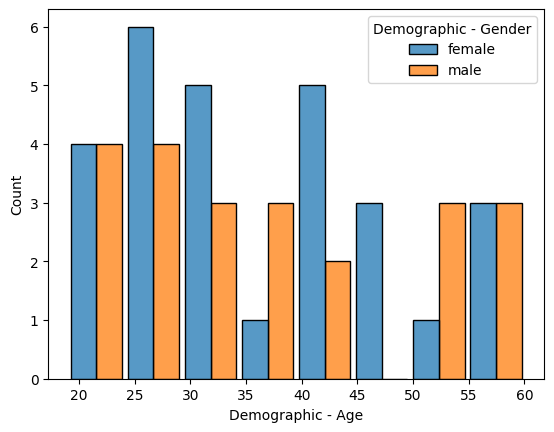

In [71]:
# Get the max and min age
print(demographics["Demographic - Age"].max(), demographics["Demographic - Age"].min())

# convert the age to a numeric value
demographics["Demographic - Age"] = pd.to_numeric(
    demographics["Demographic - Age"], errors="coerce"
)

# graph an histogram of the ages
sns.histplot(
    data=demographics,
    x="Demographic - Age",
    binwidth=5,
    hue="Demographic - Gender",
    multiple="dodge",
    shrink=0.9,
)

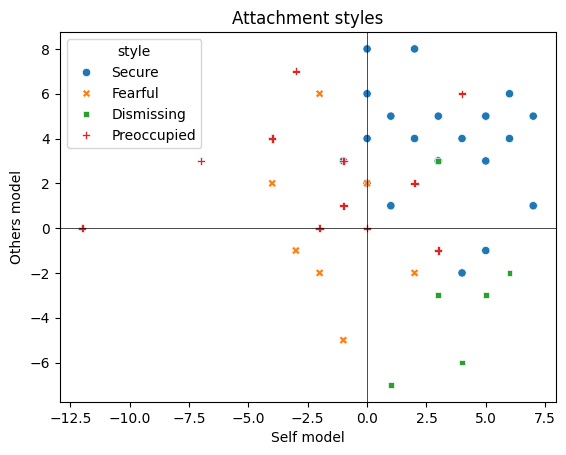

In [72]:
# graph the attachment styles from RQ Model of self (anxiety) and others (avoidance)

rq_dataframe = df.from_dict([answer.get("RQ score") for answer in full_answers])

graph = sns.scatterplot(
    data=rq_dataframe, x="anxiety", y="avoidance", hue="style", style="style"
)
graph.set_title("Attachment styles")
graph.set_xlabel("Self model")
graph.set_ylabel("Others model")
graph.axhline(0, color="black", linewidth=0.5)
graph.axvline(0, color="black", linewidth=0.5)
plt.show()

In [73]:
# Categorize the persons by styles from the anxiety and avoidance cuadrants of the RQ model
# Secure if coordinates are bigger than 0, 0, insecure otherwise. For the ambiguous cases check the style

df["RQ1_style"] = df["RQ_result_style"].apply(lambda x: "Secure" if x == "Secure" else "Insecure")

for answer in full_answers:
    if (
        answer.get("RQ score").get("anxiety") > 0
        and answer.get("RQ score").get("avoidance") > 0
    ):
        answer["RQ2_style"] = "secure"
    elif (
        answer.get("RQ score").get("anxiety") < 0
        or answer.get("RQ score").get("avoidance") < 0
    ):
        answer["RQ2_style"] = "insecure"
    else:
        print(f"answer with anxiety {answer.get('RQ score').get('anxiety')} and avoidance {answer.get('RQ score').get('avoidance')} is ambiguous")
        if answer.get("RQ score").get("anxiety") == 0 and answer.get("RQ score").get("avoidance") > 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("anxiety") > 0 and answer.get("RQ score").get("avoidance") == 0:
            answer["RQ2_style"] = "secure"
        elif answer.get("RQ score").get("style").lower() == "secure":
            answer["RQ2_style"] = "secure"
        else:
            answer["RQ2_style"] = "insecure"
        print(answer.get("RQ2_style"))

# get a dataframe with the attachment styles from RQ2
rq2_dataframe = pd.DataFrame(full_answers)
rq2_dataframe.describe()

answer with anxiety 0 and avoidance 2 is ambiguous
secure
answer with anxiety 0 and avoidance 0 is ambiguous
insecure
answer with anxiety 0 and avoidance 6 is ambiguous
secure
answer with anxiety 0 and avoidance 4 is ambiguous
secure
answer with anxiety 0 and avoidance 8 is ambiguous
secure
answer with anxiety 0 and avoidance 2 is ambiguous
secure


,id,HADS score - Anxiety,HADS score - Depression,llm_anxiety_average,llm_depression_average,image_1_llm_anxiety,image_1_llm_depression,image_2_llm_anxiety,image_2_llm_depression,image_3_llm_anxiety,...,description_llm_anxiety,description_llm_depression,past_llm_anxiety,past_llm_depression,present_llm_anxiety,present_llm_depression,future_llm_anxiety,future_llm_depression,RQ_self_model,RQ_others_model
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1106.300000,7.300000,7.180000,44.987500,27.212500,30.650000,18.725000,33.450000,19.650000,37.350000,...,42.275000,25.612500,48.225000,28.375000,50.550000,31.825000,38.900000,23.037500,1.280000,1.920000
std,495.752788,3.929221,2.496446,8.718731,5.915083,14.921649,8.543444,15.376981,8.101083,14.253625,...,10.087911,7.112088,12.021691,7.950942,11.429018,9.752878,10.701302,6.544113,3.812118,3.469047
min,119.000000,0.000000,2.000000,28.750000,17.343750,15.000000,3.750000,15.000000,3.750000,15.000000,...,25.000000,11.875000,25.000000,14.375000,27.500000,11.875000,20.000000,12.500000,-12.000000,-7.000000
25%,836.750000,4.000000,6.000000,38.125000,22.695312,20.000000,13.750000,20.000000,15.000000,30.000000,...,35.000000,20.000000,40.000000,21.562500,42.500000,24.531250,32.500000,18.906250,-1.000000,0.000000
50%,1174.500000,7.000000,7.000000,44.062500,26.562500,27.500000,16.875000,30.000000,18.750000,35.000000,...,43.750000,26.562500,46.250000,26.250000,50.000000,30.625000,35.625000,22.500000,1.500000,2.500000
75%,1375.000000,11.000000,9.000000,50.937500,31.367188,39.375000,22.500000,43.750000,23.437500,45.000000,...,50.000000,30.625000,55.000000,34.843750,60.000000,38.593750,44.375000,25.937500,4.000000,4.000000
max,1789.000000,15.000000,13.000000,67.500000,39.375000,80.000000,47.500000,80.000000,40.000000,75.000000,...,62.500000,40.625000,77.500000,48.750000,70.000000,51.875000,80.000000,47.500000,7.000000,8.000000


#### Get the ROC curve
The analysis includes some segmentations of the population:
- Per gender
- Secure and Insecure styles
- Considering only the self reported answered from RQ (Also RQ1 in other places)

Accuracy rates - full sample RQ 2
46
llm                24
llm_image_1        25
llm_image_2        23
llm_image_3        23
llm_image_4        23
llm_image_5        24
llm_image_6        20
llm_image_7        24
llm_image_8        26
llm_description    24
llm_past           24
llm_present        24
llm_future         23
dtype: int64
True Positive rate: 
 llm                0.52
llm_image_1        0.54
llm_image_2        0.50
llm_image_3        0.50
llm_image_4        0.50
llm_image_5        0.52
llm_image_6        0.43
llm_image_7        0.52
llm_image_8        0.57
llm_description    0.52
llm_past           0.52
llm_present        0.52
llm_future         0.50
dtype: float64
False Positive rate: 
 llm                0.48
llm_image_1        0.46
llm_image_2        0.50
llm_image_3        0.50
llm_image_4        0.50
llm_image_5        0.48
llm_image_6        0.57
llm_image_7        0.48
llm_image_8        0.43
llm_description    0.48
llm_past           0.48
llm_present        0.48
llm_

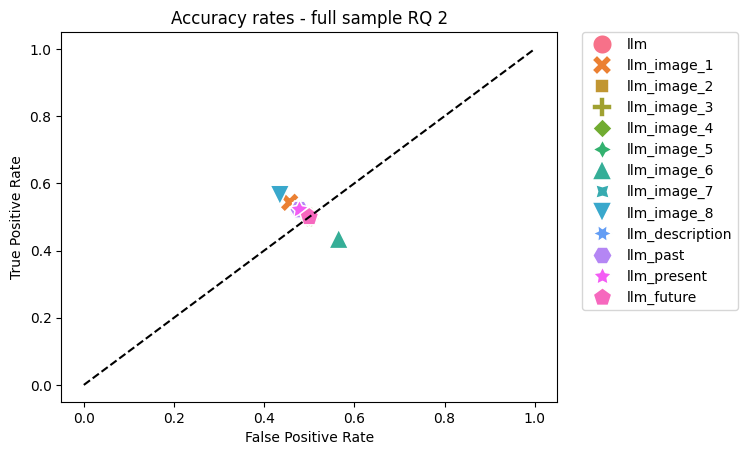

Accuracy rates - secure sample RQ 2
24
llm                16
llm_image_1        22
llm_image_2        18
llm_image_3        16
llm_image_4        19
llm_image_5        17
llm_image_6        10
llm_image_7        11
llm_image_8        21
llm_description    20
llm_past           14
llm_present        12
llm_future         20
dtype: int64
True Positive rate: 
 llm                0.67
llm_image_1        0.92
llm_image_2        0.75
llm_image_3        0.67
llm_image_4        0.79
llm_image_5        0.71
llm_image_6        0.42
llm_image_7        0.46
llm_image_8        0.88
llm_description    0.83
llm_past           0.58
llm_present        0.50
llm_future         0.83
dtype: float64
False Positive rate: 
 llm                0.33
llm_image_1        0.08
llm_image_2        0.25
llm_image_3        0.33
llm_image_4        0.21
llm_image_5        0.29
llm_image_6        0.58
llm_image_7        0.54
llm_image_8        0.12
llm_description    0.17
llm_past           0.42
llm_present        0.50
ll

/tmp/ipykernel_2556/1605830691.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2556/1605830691.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


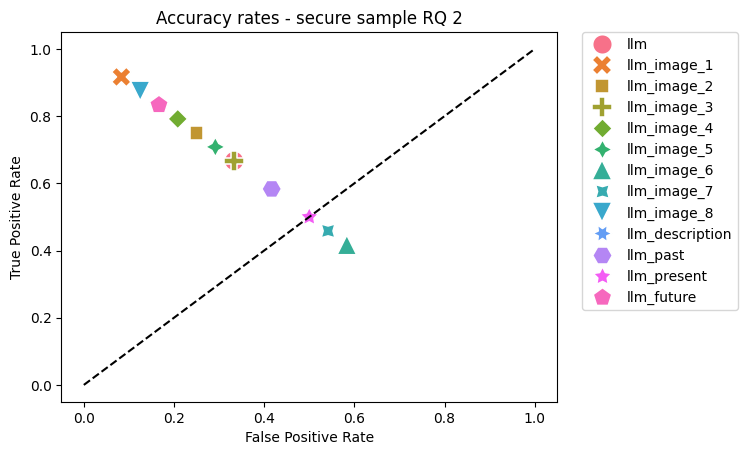

Accuracy rates - insecure sample RQ 2
22
llm                 8
llm_image_1         3
llm_image_2         5
llm_image_3         7
llm_image_4         4
llm_image_5         7
llm_image_6        10
llm_image_7        13
llm_image_8         5
llm_description     4
llm_past           10
llm_present        12
llm_future          3
dtype: int64
True Positive rate: 
 llm                0.36
llm_image_1        0.14
llm_image_2        0.23
llm_image_3        0.32
llm_image_4        0.18
llm_image_5        0.32
llm_image_6        0.45
llm_image_7        0.59
llm_image_8        0.23
llm_description    0.18
llm_past           0.45
llm_present        0.55
llm_future         0.14
dtype: float64
False Positive rate: 
 llm                0.64
llm_image_1        0.86
llm_image_2        0.77
llm_image_3        0.68
llm_image_4        0.82
llm_image_5        0.68
llm_image_6        0.55
llm_image_7        0.41
llm_image_8        0.77
llm_description    0.82
llm_past           0.55
llm_present        0.45


/tmp/ipykernel_2556/1605830691.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2556/1605830691.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


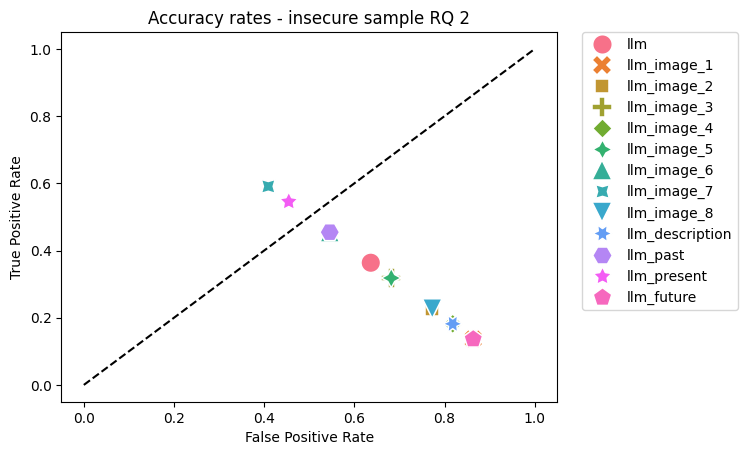

Accuracy rates - female sample RQ 2
27
llm                14
llm_image_1        15
llm_image_2        14
llm_image_3        14
llm_image_4        12
llm_image_5        13
llm_image_6        11
llm_image_7        14
llm_image_8        15
llm_description    13
llm_past           15
llm_present        15
llm_future         14
dtype: int64
True Positive rate: 
 llm                0.52
llm_image_1        0.56
llm_image_2        0.52
llm_image_3        0.52
llm_image_4        0.44
llm_image_5        0.48
llm_image_6        0.41
llm_image_7        0.52
llm_image_8        0.56
llm_description    0.48
llm_past           0.56
llm_present        0.56
llm_future         0.52
dtype: float64
False Positive rate: 
 llm                0.48
llm_image_1        0.44
llm_image_2        0.48
llm_image_3        0.48
llm_image_4        0.56
llm_image_5        0.52
llm_image_6        0.59
llm_image_7        0.48
llm_image_8        0.44
llm_description    0.52
llm_past           0.44
llm_present        0.44
ll

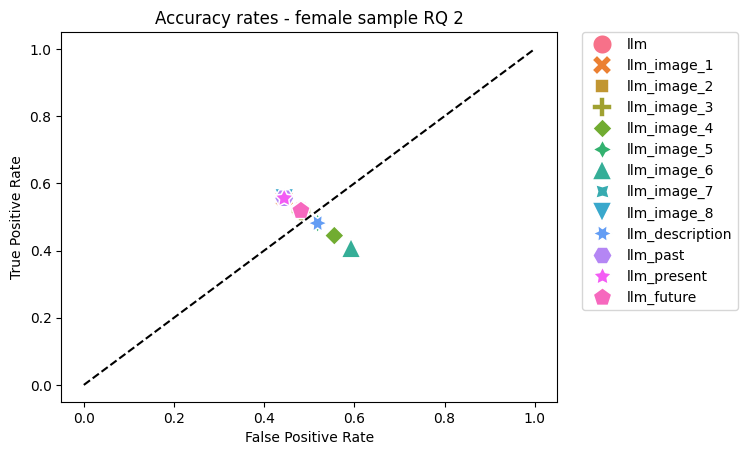

Accuracy rates - male sample RQ 2
19
llm                10
llm_image_1        10
llm_image_2         9
llm_image_3         9
llm_image_4        11
llm_image_5        11
llm_image_6         9
llm_image_7        10
llm_image_8        11
llm_description    11
llm_past            9
llm_present         9
llm_future          9
dtype: int64
True Positive rate: 
 llm                0.53
llm_image_1        0.53
llm_image_2        0.47
llm_image_3        0.47
llm_image_4        0.58
llm_image_5        0.58
llm_image_6        0.47
llm_image_7        0.53
llm_image_8        0.58
llm_description    0.58
llm_past           0.47
llm_present        0.47
llm_future         0.47
dtype: float64
False Positive rate: 
 llm                0.47
llm_image_1        0.47
llm_image_2        0.53
llm_image_3        0.53
llm_image_4        0.42
llm_image_5        0.42
llm_image_6        0.53
llm_image_7        0.47
llm_image_8        0.42
llm_description    0.42
llm_past           0.53
llm_present        0.53
llm_

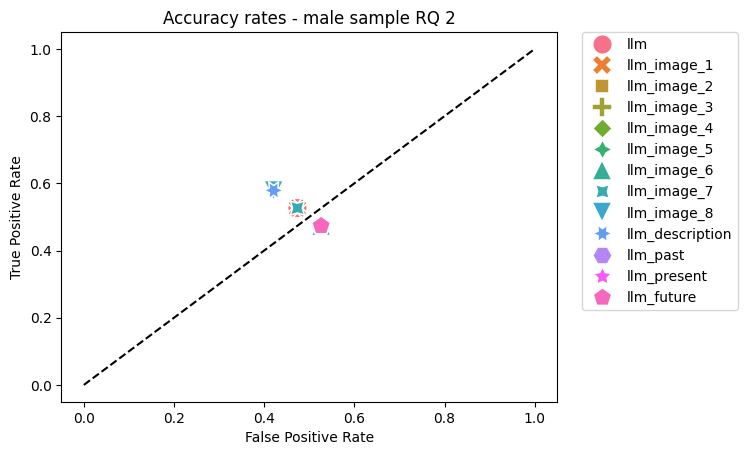

Accuracy rates - full sample RQ 1
46
llm                25
llm_image_1        26
llm_image_2        26
llm_image_3        22
llm_image_4        26
llm_image_5        27
llm_image_6        21
llm_image_7        25
llm_image_8        25
llm_description    27
llm_past           27
llm_present        25
llm_future         24
dtype: int64
True Positive rate: 
 llm                0.54
llm_image_1        0.57
llm_image_2        0.57
llm_image_3        0.48
llm_image_4        0.57
llm_image_5        0.59
llm_image_6        0.46
llm_image_7        0.54
llm_image_8        0.54
llm_description    0.59
llm_past           0.59
llm_present        0.54
llm_future         0.52
dtype: float64
False Positive rate: 
 llm                0.46
llm_image_1        0.43
llm_image_2        0.43
llm_image_3        0.52
llm_image_4        0.43
llm_image_5        0.41
llm_image_6        0.54
llm_image_7        0.46
llm_image_8        0.46
llm_description    0.41
llm_past           0.41
llm_present        0.46
llm_

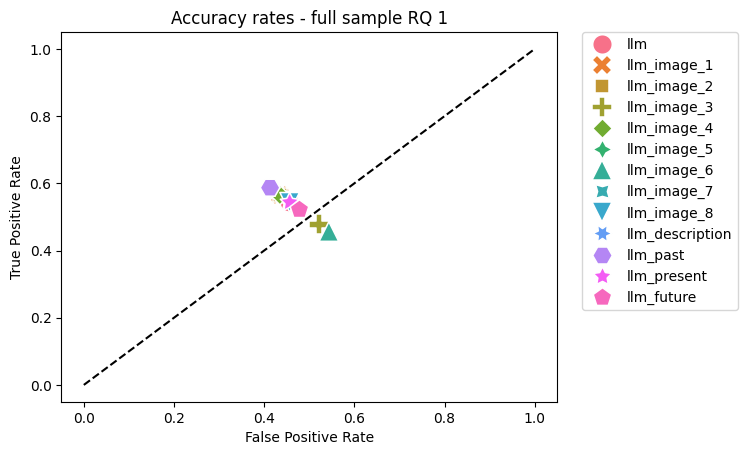

Accuracy rates - secure sample RQ 1
25
llm                17
llm_image_1        23
llm_image_2        20
llm_image_3        16
llm_image_4        21
llm_image_5        19
llm_image_6        11
llm_image_7        12
llm_image_8        21
llm_description    22
llm_past           16
llm_present        13
llm_future         21
dtype: int64
True Positive rate: 
 llm                0.68
llm_image_1        0.92
llm_image_2        0.80
llm_image_3        0.64
llm_image_4        0.84
llm_image_5        0.76
llm_image_6        0.44
llm_image_7        0.48
llm_image_8        0.84
llm_description    0.88
llm_past           0.64
llm_present        0.52
llm_future         0.84
dtype: float64
False Positive rate: 
 llm                0.32
llm_image_1        0.08
llm_image_2        0.20
llm_image_3        0.36
llm_image_4        0.16
llm_image_5        0.24
llm_image_6        0.56
llm_image_7        0.52
llm_image_8        0.16
llm_description    0.12
llm_past           0.36
llm_present        0.48
ll

/tmp/ipykernel_2556/1605830691.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2556/1605830691.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


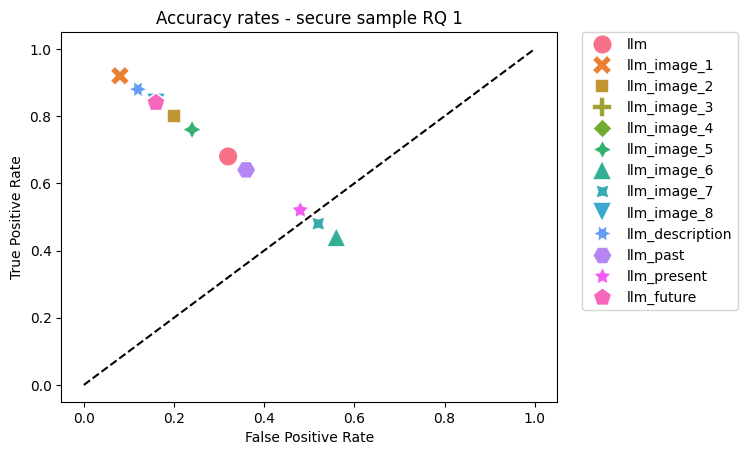

Accuracy rates - insecure sample RQ 1
21
llm                 8
llm_image_1         3
llm_image_2         6
llm_image_3         6
llm_image_4         5
llm_image_5         8
llm_image_6        10
llm_image_7        13
llm_image_8         4
llm_description     5
llm_past           11
llm_present        12
llm_future          3
dtype: int64
True Positive rate: 
 llm                0.38
llm_image_1        0.14
llm_image_2        0.29
llm_image_3        0.29
llm_image_4        0.24
llm_image_5        0.38
llm_image_6        0.48
llm_image_7        0.62
llm_image_8        0.19
llm_description    0.24
llm_past           0.52
llm_present        0.57
llm_future         0.14
dtype: float64
False Positive rate: 
 llm                0.62
llm_image_1        0.86
llm_image_2        0.71
llm_image_3        0.71
llm_image_4        0.76
llm_image_5        0.62
llm_image_6        0.52
llm_image_7        0.38
llm_image_8        0.81
llm_description    0.76
llm_past           0.48
llm_present        0.43


/tmp/ipykernel_2556/1605830691.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[column] = df_data.apply(
/tmp/ipykernel_2556/1605830691.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.drop(columns=["RQ"], inplace=True)


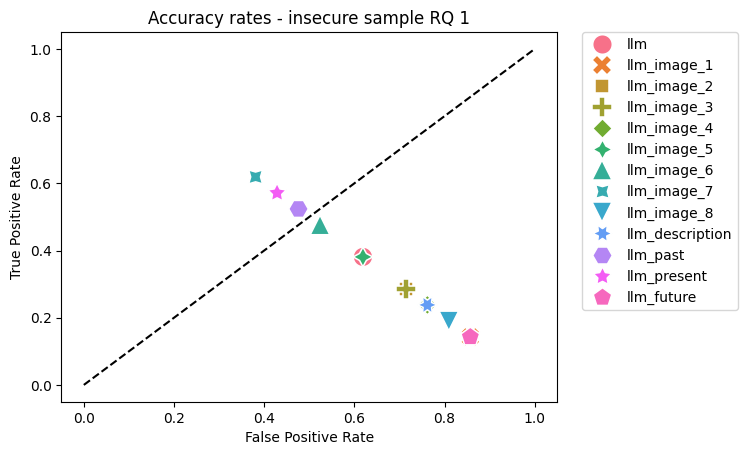

Accuracy rates - female sample RQ 1
27
llm                15
llm_image_1        14
llm_image_2        15
llm_image_3        13
llm_image_4        13
llm_image_5        14
llm_image_6        12
llm_image_7        15
llm_image_8        14
llm_description    14
llm_past           16
llm_present        16
llm_future         13
dtype: int64
True Positive rate: 
 llm                0.56
llm_image_1        0.52
llm_image_2        0.56
llm_image_3        0.48
llm_image_4        0.48
llm_image_5        0.52
llm_image_6        0.44
llm_image_7        0.56
llm_image_8        0.52
llm_description    0.52
llm_past           0.59
llm_present        0.59
llm_future         0.48
dtype: float64
False Positive rate: 
 llm                0.44
llm_image_1        0.48
llm_image_2        0.44
llm_image_3        0.52
llm_image_4        0.52
llm_image_5        0.48
llm_image_6        0.56
llm_image_7        0.44
llm_image_8        0.48
llm_description    0.48
llm_past           0.41
llm_present        0.41
ll

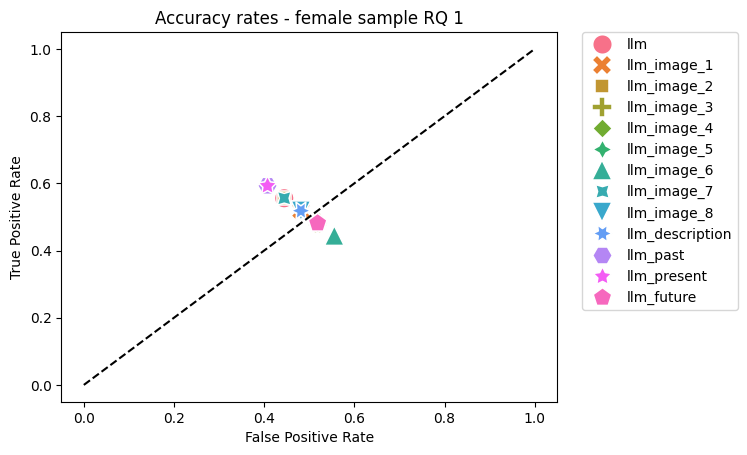

Accuracy rates - male sample RQ 1
19
llm                10
llm_image_1        12
llm_image_2        11
llm_image_3         9
llm_image_4        13
llm_image_5        13
llm_image_6         9
llm_image_7        10
llm_image_8        11
llm_description    13
llm_past           11
llm_present         9
llm_future         11
dtype: int64
True Positive rate: 
 llm                0.53
llm_image_1        0.63
llm_image_2        0.58
llm_image_3        0.47
llm_image_4        0.68
llm_image_5        0.68
llm_image_6        0.47
llm_image_7        0.53
llm_image_8        0.58
llm_description    0.68
llm_past           0.58
llm_present        0.47
llm_future         0.58
dtype: float64
False Positive rate: 
 llm                0.47
llm_image_1        0.37
llm_image_2        0.42
llm_image_3        0.53
llm_image_4        0.32
llm_image_5        0.32
llm_image_6        0.53
llm_image_7        0.47
llm_image_8        0.42
llm_description    0.32
llm_past           0.42
llm_present        0.53
llm_

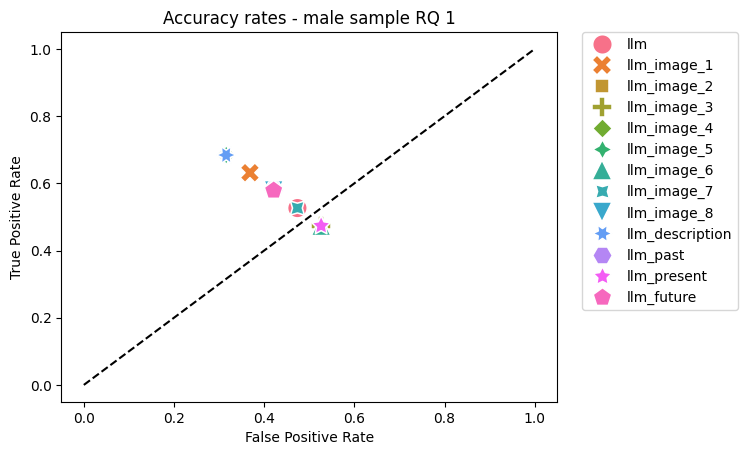

In [74]:
df_style_female_rq2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "female"
        and answer.get("RQ valid")
    ]
)

def_style_male_rq2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "male"
        and answer.get("RQ valid")
    ]
)


df_style_rq_2 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ2_style"),
        }
        for answer in full_answers
        if answer.get("RQ valid")
    ]
)

df_style_rq_1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in full_answers
        if answer.get("RQ valid")
    ]
)

df_style_female_rq1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "female"
        and answer.get("RQ valid")
    ]
)

def_style_male_rq1 = df.from_dict(
    [
        {
            "llm": answer.get("llm_attachment_styles_percentages"),
            "llm_image_1": answer.get("image_1_llm_style"),
            "llm_image_2": answer.get("image_2_llm_style"),
            "llm_image_3": answer.get("image_3_llm_style"),
            "llm_image_4": answer.get("image_4_llm_style"),
            "llm_image_5": answer.get("image_5_llm_style"),
            "llm_image_6": answer.get("image_6_llm_style"),
            "llm_image_7": answer.get("image_7_llm_style"),
            "llm_image_8": answer.get("image_8_llm_style"),
            "llm_description": answer.get("description_llm_style"),
            "llm_past": answer.get("past_llm_style"),
            "llm_present": answer.get("present_llm_style"),
            "llm_future": answer.get("future_llm_style"),
            "RQ": answer.get("RQ_result_style"),
        }
        for answer in  full_answers if answer.get("Demographic - Gender") == "male"
        and answer.get("RQ valid")
    ]
)


df_style_rq_2_secure = df_style_rq_2[df_style_rq_2["RQ"] == "secure"]
df_style_rq_2_insecure = df_style_rq_2[df_style_rq_2["RQ"] == "insecure"]

df_style_rq_1_secure = df_style_rq_1[df_style_rq_1["RQ"] == "Secure"]
df_style_rq_1_insecure = df_style_rq_1[df_style_rq_1["RQ"] != "Secure"]

df_styling_dict = [
    {"data": df_style_rq_2, "title": "Accuracy rates - full sample RQ 2"},
    {"data": df_style_rq_2_secure, "title": "Accuracy rates - secure sample RQ 2"},
    {"data": df_style_rq_2_insecure, "title": "Accuracy rates - insecure sample RQ 2"},
    {"data": df_style_female_rq2, "title": "Accuracy rates - female sample RQ 2"},
    {"data": def_style_male_rq2, "title": "Accuracy rates - male sample RQ 2"},
    {"data": df_style_rq_1, "title": "Accuracy rates - full sample RQ 1"},
    {"data": df_style_rq_1_secure, "title": "Accuracy rates - secure sample RQ 1"},
    {"data": df_style_rq_1_insecure, "title": "Accuracy rates - insecure sample RQ 1"},
    {"data": df_style_female_rq1, "title": "Accuracy rates - female sample RQ 1"},
    {"data": def_style_male_rq1, "title": "Accuracy rates - male sample RQ 1"},
]

def custom_is_equal(llm: str, rq: str) -> bool:
    rq_lower = rq.lower()
    llm_lower = llm.lower()
    if rq_lower != "secure":
        rq_lower = "insecure"
    if llm_lower != "secure":
        llm_lower = "insecure"
    return llm == rq_lower


# Compare each column with the RQ style and set the value to 1 if they match and 0 if they don't
for roc_style_data in df_styling_dict:
    # print the length of the dataframe
    df_data = roc_style_data.get("data")
    print(roc_style_data.get("title"))
    print(len(df_data))
    for column in df_data.columns:
        if column == "RQ":
            continue
        df_data[column] = df_data.apply(
            lambda x: 1 if custom_is_equal(x.get(column), x.get("RQ")) else 0, axis=1
        )

    df_data.drop(columns=["RQ"], inplace=True)

    # get the percentage of matches per column
    matches = df_data.sum()
    print(matches)
    # Calculate the False Positive Rate and True Positive Rate

    int_matches = matches.astype(int)
    true_positive_rate = int_matches / len(df_data)
    false_positive_rate = 1 - true_positive_rate
    # print the rates rounded to two decimals
    print("True Positive rate: \n", round(true_positive_rate, 2))
    print("False Positive rate: \n", round(false_positive_rate, 2))

    # Calculate the ROC curve
    roc_curve = pd.DataFrame(
        {
            "False Positive Rate": false_positive_rate,
            "True Positive Rate": true_positive_rate,
        }
    )

    graph = sns.scatterplot(
        data=roc_curve,
        x="False Positive Rate",
        y="True Positive Rate",
        hue=roc_curve.index,
        style=roc_curve.index,
        s=200,
    )

    # Add the diagonal line
    graph.plot([0, 1], [0, 1], color="black", linestyle="--")
    graph.set_title(roc_style_data.get("title"))
    # put the legend outside the graph
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    #show the high definition graph
    plt.show()

#### HADS comparison with the secondary data points for anxiety and depression from the LLM

In [75]:
# get HADS scores and llm depression and anxiety averages
df["llm_depression_average"] = df["llm_depression_average"].apply(
    lambda x: int(x) if x is not None else None
)
df["llm_anxiety_average"] = df["llm_anxiety_average"].apply(
    lambda x: int(x) if x is not None else None
)

# Standardize the HADS scores to 0-100.00 where 0 is the minimum and 21 is the maximum
# add a new column with the standard values
df.insert(
    len(df.columns),
    "HADS score - Anxiety 100",
    (
        df["HADS score - Anxiety"].apply(
            lambda x: round((x / 21) * 100, 2) if x is not None else None
        )
    ),
)

df.insert(
    len(df.columns),
    "HADS score - Depression 100",
    (
        df["HADS score - Depression"].apply(
            lambda x: round((x / 21) * 100, 2) if x is not None else None
        )
    ),
)

df.insert(
    len(df.columns),
    "depression_distance",
    (df["HADS score - Depression 100"] - df["llm_depression_average"]),
)
df.insert(
    len(df.columns),
    "anxiety_distance",
    (df["HADS score - Anxiety 100"] - df["llm_anxiety_average"]),
)

# print the columns with the HADS score and the llm depression and anxiety averages as a table
df[
    [
        "HADS score - Anxiety 100",
        "llm_anxiety_average",
        "HADS score - Depression 100",
        "llm_depression_average",
    ]
].describe()

,HADS score - Anxiety 100,llm_anxiety_average,HADS score - Depression 100,llm_depression_average
count,50.000000,50.000000,50.000000,50.000000
mean,34.761800,44.540000,34.190600,26.680000
std,18.709962,8.809109,11.887547,5.939972
min,0.000000,28.000000,9.520000,17.000000
25%,19.050000,38.000000,28.570000,22.000000
50%,33.330000,43.500000,33.330000,26.000000
75%,52.380000,50.750000,42.860000,30.750000
max,71.430000,67.000000,61.900000,39.000000


In [76]:
# Graph the average distance from the HADS scores to the ones selected by the LLM
df[["depression_distance", "anxiety_distance"]].describe()

,depression_distance,anxiety_distance
count,50.00000,50.000000
mean,7.51060,-9.778200
std,12.91158,19.183693
min,-21.71000,-47.950000
25%,0.94000,-21.890000
50%,6.81000,-8.310000
75%,16.18000,2.680000
max,37.90000,25.900000


In [77]:
# generate distances for each image and the description, past, present and future
for img_num in range(1, 9):
    df.insert(
        len(df.columns),
        f"image_{img_num}_depression_distance",
        (df[f"image_{img_num}_llm_depression"] - df["HADS score - Depression 100"]),
    )
    df.insert(
        len(df.columns),
        f"image_{img_num}_anxiety_distance",
        (df[f"image_{img_num}_llm_anxiety"] - df["HADS score - Anxiety 100"]),
    )

df.insert(
    len(df.columns),
    "description_depression_distance",
    (df["description_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "description_anxiety_distance",
    (df["description_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "past_depression_distance",
    (df["past_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "past_anxiety_distance",
    (df["past_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "present_depression_distance",
    (df["present_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "present_anxiety_distance",
    (df["present_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

df.insert(
    len(df.columns),
    "future_depression_distance",
    (df["future_llm_depression"] - df["HADS score - Depression 100"]),
)
df.insert(
    len(df.columns),
    "future_anxiety_distance",
    (df["future_llm_anxiety"] - df["HADS score - Anxiety 100"]),
)

In [78]:
df[[col for col in df.columns if "distance" in col]].describe()

,depression_distance,anxiety_distance,image_1_depression_distance,image_1_anxiety_distance,image_2_depression_distance,image_2_anxiety_distance,image_3_depression_distance,image_3_anxiety_distance,image_4_depression_distance,image_4_anxiety_distance,...,image_8_depression_distance,image_8_anxiety_distance,description_depression_distance,description_anxiety_distance,past_depression_distance,past_anxiety_distance,present_depression_distance,present_anxiety_distance,future_depression_distance,future_anxiety_distance
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.00000,50.000000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,7.51060,-9.778200,-15.465600,-4.111800,-14.540600,-1.311800,-12.490600,2.588200,-11.165600,5.338200,...,-12.665600,3.738200,-8.57810,7.513200,-5.81560,13.46320,-2.365600,15.788200,-11.153100,4.138200
std,12.91158,19.183693,14.504366,21.838748,14.465391,21.673466,15.765049,21.950929,17.190507,22.340679,...,15.367288,21.614055,12.79927,20.519261,13.27309,19.68194,15.483795,19.998174,13.987314,21.091564
min,-21.71000,-47.950000,-56.900000,-51.430000,-58.150000,-41.900000,-53.150000,-41.900000,-45.650000,-41.900000,...,-45.890000,-31.900000,-36.27500,-31.900000,-39.40000,-22.62000,-30.025000,-19.400000,-44.400000,-31.900000
25%,0.94000,-21.890000,-24.290000,-17.800000,-22.202500,-12.320000,-21.595000,-9.312500,-21.610000,-12.142500,...,-21.610000,-11.427500,-16.67375,-8.092500,-10.97000,-0.95000,-13.040000,1.682500,-19.193750,-9.580000
50%,6.81000,-8.310000,-17.115000,-3.930000,-15.835000,-3.215000,-15.090000,3.570000,-11.695000,5.835000,...,-12.230000,1.785000,-6.84500,8.035000,-6.60500,12.32000,-2.945000,14.645000,-9.970000,3.035000
75%,16.18000,2.680000,-4.880000,10.240000,-4.302500,11.610000,-3.052500,20.592500,-2.425000,20.712500,...,-3.822500,15.890000,-0.22875,21.550000,-0.03625,25.89000,7.067500,28.930000,-4.015000,16.490000
max,37.90000,25.900000,14.170000,50.950000,16.190000,60.950000,22.680000,55.950000,29.230000,55.950000,...,16.960000,60.480000,21.73000,42.740000,26.33500,55.48000,37.585000,57.980000,23.690000,60.950000


Text(0.5, 0, 'Difference')

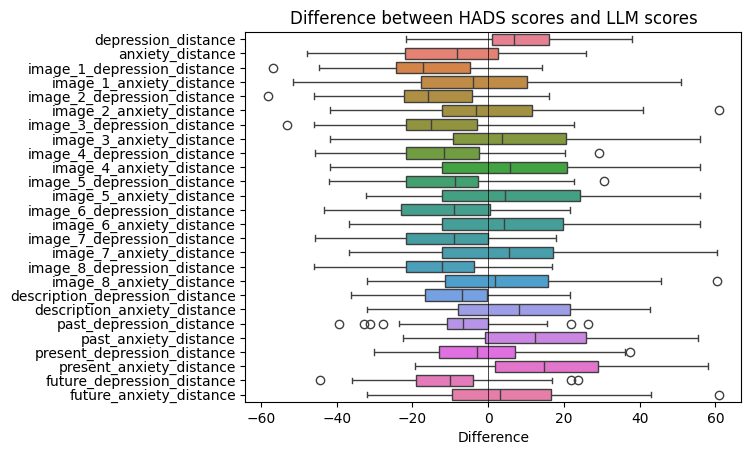

In [79]:
# graph the distances
graph = sns.boxplot(
    data=df[[col for col in df.columns if "distance" in col]],
    orient="h",
    gap=0.01,
)
graph.set_title("Difference between HADS scores and LLM scores")
graph.axvline(0, color="black", linewidth=0.5)
graph.set_xlabel("Difference")

/tmp/ipykernel_2556/2404488468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]
/tmp/ipykernel_2556/2404488468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]


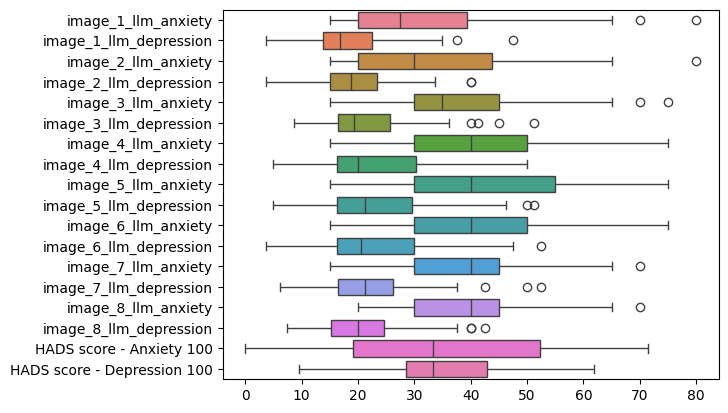

In [80]:
image_df = df[[col for col in df.columns if "image" in col and "llm" in col]]

# Add the HADS scores to the dataframe
image_df["HADS score - Anxiety 100"] = df["HADS score - Anxiety 100"]
image_df["HADS score - Depression 100"] = df["HADS score - Depression 100"]

# graph the distances for each image
graph = sns.boxplot(
    data=image_df,
    orient="h",
    gap=0.01,
)

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            50.000000            50.000000            50.000000   
mean             44.540000            30.650000            33.450000   
std               8.809109            14.921649            15.376981   
min              28.000000            15.000000            15.000000   
25%              38.000000            20.000000            20.000000   
50%              43.500000            27.500000            30.000000   
75%              50.750000            39.375000            43.750000   
max              67.000000            80.000000            80.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            50.000000             50.00000            50.000000   
mean             37.350000             40.10000            41.600000   
std              14.253625             16.01944            16.176324   
min              15.000000             15.00000            15.0

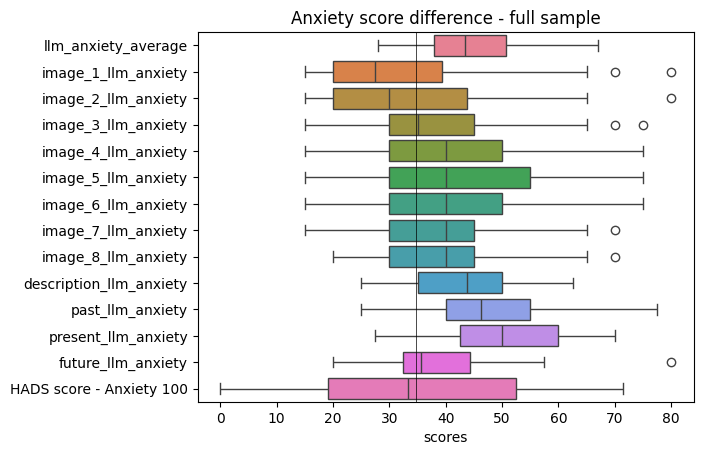

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            28.000000            28.000000            28.000000   
mean             43.857143            27.410714            30.446429   
std               7.648356             9.941545            12.510247   
min              28.000000            15.000000            15.000000   
25%              37.500000            20.000000            20.000000   
50%              44.500000            22.500000            27.500000   
75%              49.500000            35.000000            41.250000   
max              60.000000            50.000000            55.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            28.000000            28.000000            28.000000   
mean             35.446429            38.928571            40.535714   
std              13.540980            16.006778            16.518188   
min              20.000000            15.000000            15.0

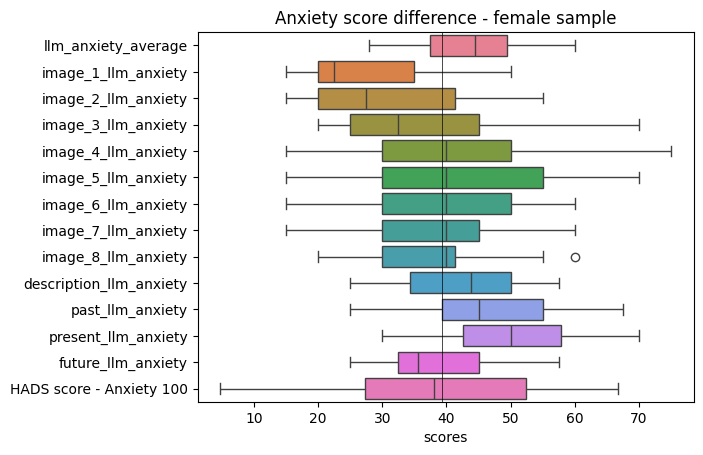

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            22.000000            22.000000            22.000000   
mean             45.409091            34.772727            37.272727   
std              10.219771            18.991055            17.976656   
min              32.000000            15.000000            15.000000   
25%              38.250000            20.000000            20.000000   
50%              42.000000            30.000000            35.000000   
75%              50.750000            43.750000            47.500000   
max              67.000000            80.000000            80.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            22.000000            22.000000            22.000000   
mean             39.772727            41.590909            42.954545   
std              15.077362            16.285135            16.010346   
min              15.000000            15.000000            20.0

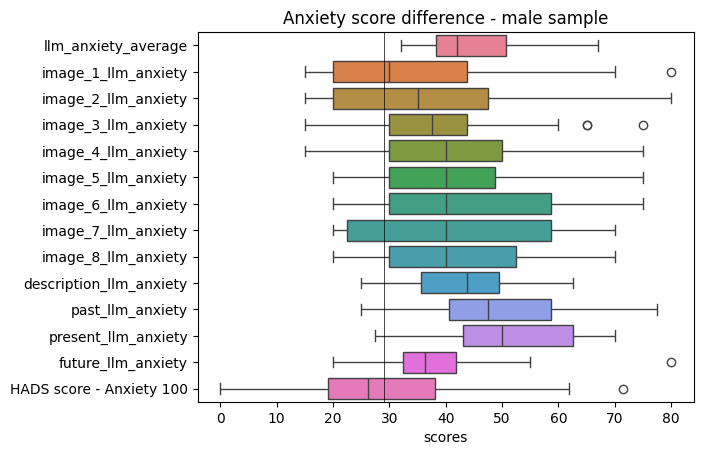

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            25.000000            25.000000            25.000000   
mean             42.840000            27.900000            29.700000   
std               7.284001            14.571662            14.330911   
min              32.000000            15.000000            15.000000   
25%              38.000000            20.000000            20.000000   
50%              42.000000            20.000000            20.000000   
75%              47.000000            35.000000            40.000000   
max              64.000000            80.000000            65.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            25.000000            25.000000            25.000000   
mean             35.100000            37.000000            38.000000   
std              13.316656            15.612495            14.648663   
min              15.000000            15.000000            15.0

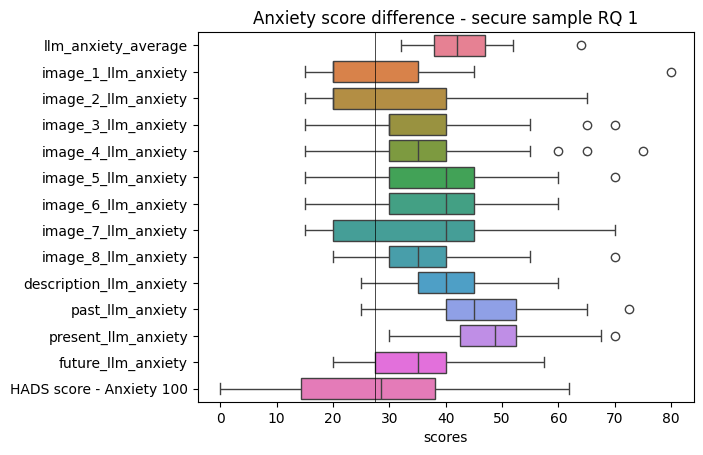

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            25.000000            25.000000            25.000000   
mean             46.240000            33.400000            37.200000   
std               9.967781            15.049917            15.750661   
min              28.000000            20.000000            20.000000   
25%              38.000000            20.000000            20.000000   
50%              48.000000            30.000000            35.000000   
75%              53.000000            40.000000            45.000000   
max              67.000000            70.000000            80.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            25.000000            25.000000            25.000000   
mean             39.600000            43.200000            45.200000   
std              15.063753            16.129683            17.107503   
min              20.000000            20.000000            20.0

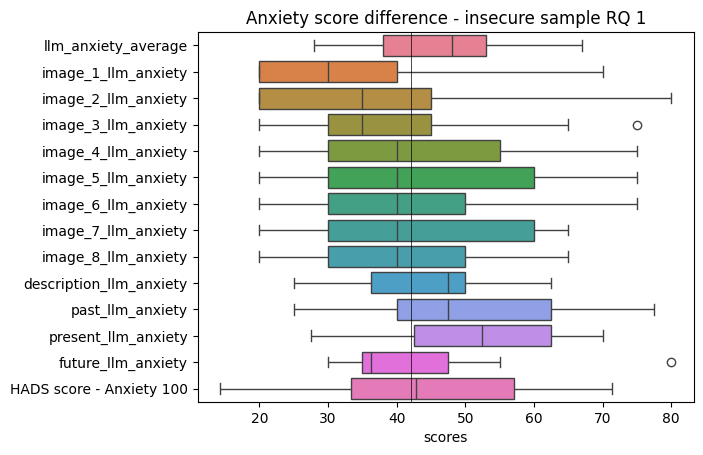

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            26.000000            26.000000            26.000000   
mean             44.115385            28.942308            31.442308   
std               8.533824            15.036174            15.299887   
min              32.000000            15.000000            15.000000   
25%              38.000000            20.000000            20.000000   
50%              42.500000            22.500000            22.500000   
75%              48.750000            35.625000            43.750000   
max              64.000000            80.000000            65.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            26.000000            26.000000            26.000000   
mean             36.826923            39.615385            40.384615   
std              13.630071            16.426995            15.806523   
min              20.000000            15.000000            15.0

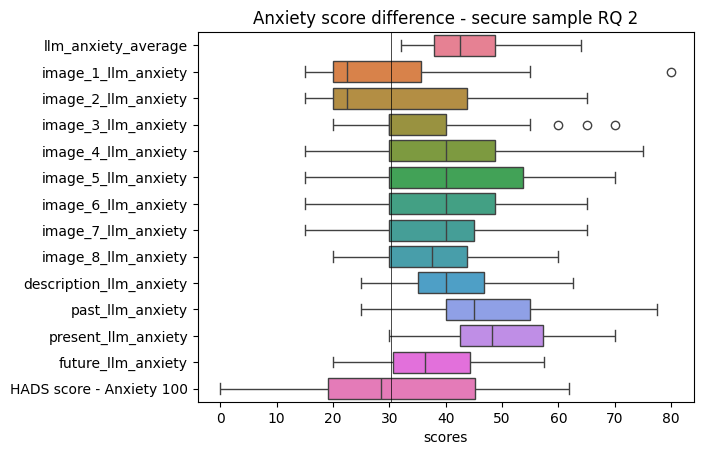

       llm_anxiety_average  image_1_llm_anxiety  image_2_llm_anxiety  \
count            24.000000            24.000000            24.000000   
mean             45.000000            32.500000            35.625000   
std               9.259543            14.890908            15.485793   
min              28.000000            15.000000            15.000000   
25%              37.500000            20.000000            20.000000   
50%              45.500000            30.000000            35.000000   
75%              51.250000            40.000000            41.250000   
max              67.000000            70.000000            80.000000   

       image_3_llm_anxiety  image_4_llm_anxiety  image_5_llm_anxiety  \
count            24.000000             24.00000            24.000000   
mean             37.916667             40.62500            42.916667   
std              15.174110             15.90136            16.805581   
min              15.000000             15.00000            20.0

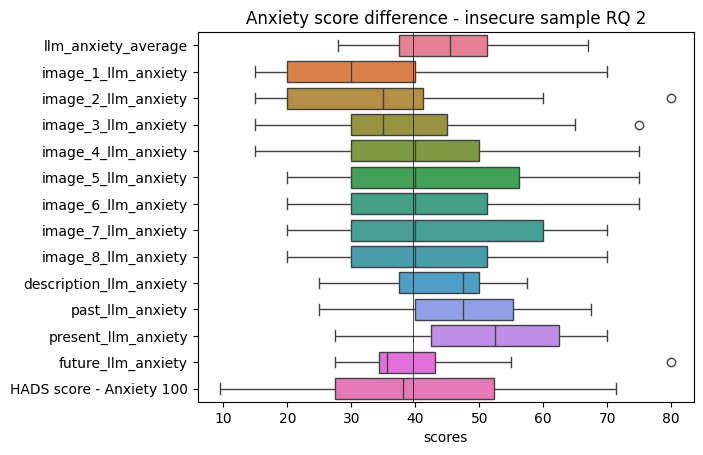

In [81]:
# Do the boxplot only for anxiety
anxiety_columns = [
    col
    for col in df.columns
    if ("anxiety" in col and "llm" in col and col != "llm_anxiety")
    or col == "HADS score - Anxiety 100"
]

anxiety_df = df[[col for col in df.columns if col in anxiety_columns]]

anxiety_df_female = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("Demographic - Gender") == "female"
    ]
)

anxiety_df_male = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("Demographic - Gender") == "male"
    ]
)

anxiety_df_rq_1_secure = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ_result_style") == "Secure"
    ]
)

anxiety_df_rq_1_insecure = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ_result_style") != "Secure"
    ]
)

anxiety__df_rq_2_secure = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ2_style") == "secure"
    ]
)

anxiety_df_rq_2_insecure = df.from_dict(
    [
        {column: answer.get(column) for column in anxiety_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ2_style") == "insecure"
    ]
)


anxiety_dfs_dict = [
    {"data": anxiety_df, "title": "Anxiety score difference - full sample"},
    {"data": anxiety_df_female, "title": "Anxiety score difference - female sample"},
    {"data": anxiety_df_male, "title": "Anxiety score difference - male sample"},
    {"data": anxiety_df_rq_1_secure, "title": "Anxiety score difference - secure sample RQ 1"},
    {"data": anxiety_df_rq_1_insecure, "title": "Anxiety score difference - insecure sample RQ 1"},
    {"data": anxiety__df_rq_2_secure, "title": "Anxiety score difference - secure sample RQ 2"},
    {"data": anxiety_df_rq_2_insecure, "title": "Anxiety score difference - insecure sample RQ 2"},
]


for anxiety_data in anxiety_dfs_dict:
    # Get the mean for HADS anxiety
    mean_anxiety = anxiety_data.get("data")["HADS score - Anxiety 100"].mean()
    print(anxiety_data.get("data").describe())
    # graph the distances for each 
    graph = sns.boxplot(
        data=anxiety_data.get("data"),
        orient="h",
        gap=0.01,
    )
    graph.axvline(mean_anxiety, color="black", linewidth=0.5)
    graph.set_title(anxiety_data.get("title"))
    graph.set_xlabel("scores")
    plt.show()

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               50.000000               50.000000               50.000000   
mean                26.680000               18.725000               19.650000   
std                  5.939972                8.543444                8.101083   
min                 17.000000                3.750000                3.750000   
25%                 22.000000               13.750000               15.000000   
50%                 26.000000               16.875000               18.750000   
75%                 30.750000               22.500000               23.437500   
max                 39.000000               47.500000               40.000000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               50.000000               50.000000               50.000000   
mean                21.700000               23.025000               23.975000   
std                  9.2090

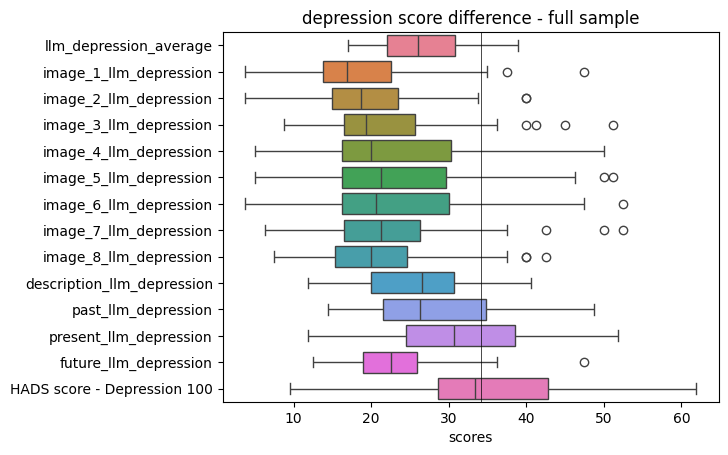

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               28.000000               28.000000               28.000000   
mean                26.642857               17.276786               18.660714   
std                  5.293002                6.028996                7.094995   
min                 17.000000                3.750000                6.250000   
25%                 22.000000               13.437500               13.437500   
50%                 26.500000               16.250000               18.750000   
75%                 30.000000               22.500000               22.812500   
max                 38.000000               31.250000               33.750000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               28.000000               28.000000               28.000000   
mean                21.160714               22.723214               23.348214   
std                  9.6280

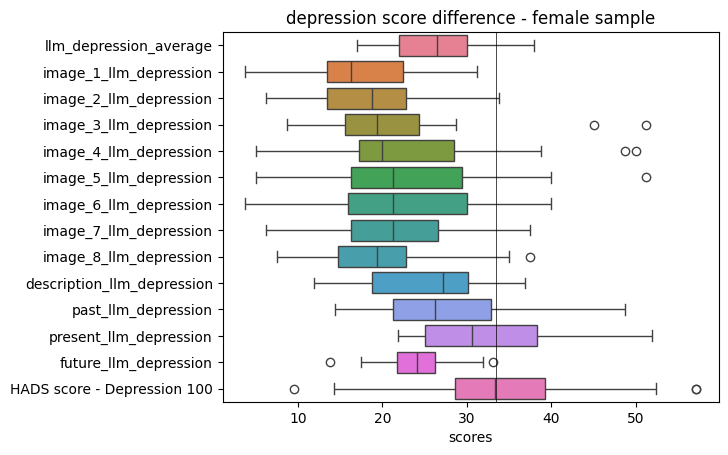

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               22.000000               22.000000               22.000000   
mean                26.727273               20.568182               20.909091   
std                  6.804633               10.826880                9.243577   
min                 17.000000                5.000000                3.750000   
25%                 22.000000               13.750000               16.250000   
50%                 25.000000               17.500000               18.750000   
75%                 33.250000               25.625000               26.250000   
max                 39.000000               47.500000               40.000000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               22.000000               22.000000               22.000000   
mean                22.386364               23.409091               24.772727   
std                  8.8212

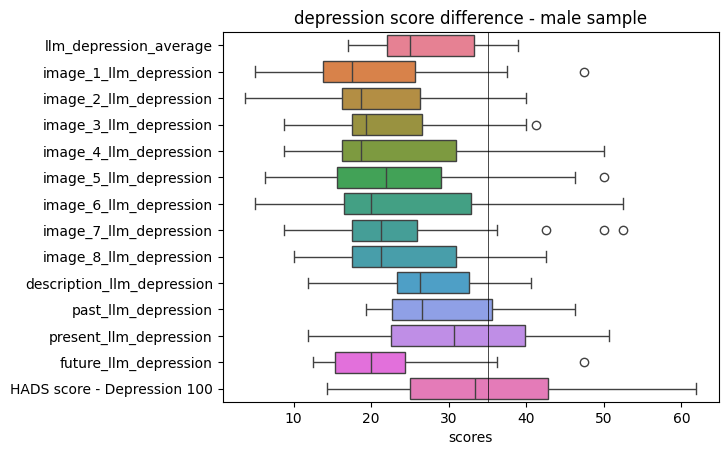

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               25.000000               25.000000               25.000000   
mean                25.480000               16.400000               17.050000   
std                  4.407569                8.936407                7.813583   
min                 17.000000                3.750000                3.750000   
25%                 23.000000               12.500000               12.500000   
50%                 25.000000               15.000000               16.250000   
75%                 28.000000               18.750000               21.250000   
max                 37.000000               47.500000               33.750000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               25.000000               25.000000                25.00000   
mean                19.550000               22.000000                22.30000   
std                  9.0490

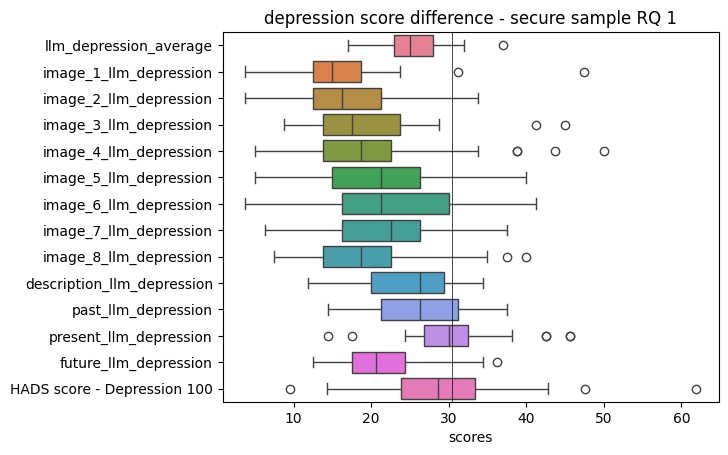

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               25.000000               25.000000               25.000000   
mean                27.880000               21.050000               22.250000   
std                  7.043437                7.609273                7.671647   
min                 17.000000               10.000000               11.250000   
25%                 21.000000               15.000000               16.250000   
50%                 29.000000               18.750000               21.250000   
75%                 35.000000               23.750000               26.250000   
max                 39.000000               37.500000               40.000000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               25.000000               25.000000                25.00000   
mean                23.850000               24.050000                25.65000   
std                  9.0349

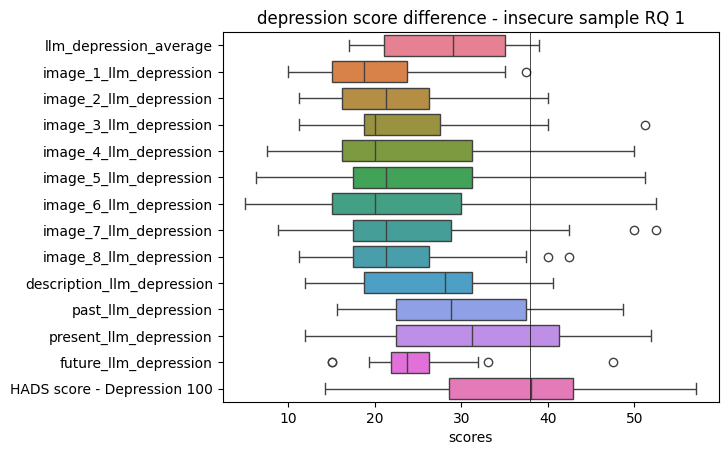

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               26.000000               26.000000               26.000000   
mean                26.423077               17.692308               18.509615   
std                  5.337963                9.491393                8.616983   
min                 17.000000                3.750000                6.250000   
25%                 22.250000               12.500000               12.812500   
50%                 26.000000               15.000000               16.250000   
75%                 29.750000               18.750000               23.437500   
max                 38.000000               47.500000               40.000000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               26.000000               26.000000               26.000000   
mean                20.528846               23.509615               23.701923   
std                  9.4945

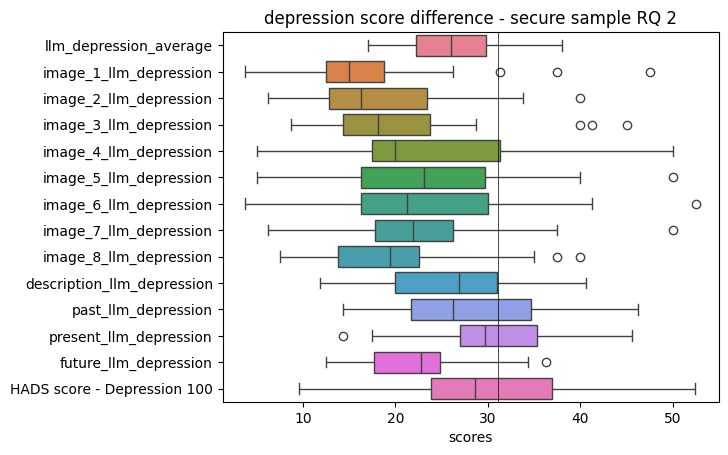

       llm_depression_average  image_1_llm_depression  image_2_llm_depression  \
count               24.000000               24.000000               24.000000   
mean                26.958333               19.843750               20.885417   
std                  6.636390                7.420892                7.486212   
min                 17.000000                5.000000                3.750000   
25%                 21.000000               14.687500               16.250000   
50%                 25.500000               18.750000               20.000000   
75%                 32.500000               22.812500               22.812500   
max                 39.000000               35.000000               40.000000   

       image_3_llm_depression  image_4_llm_depression  image_5_llm_depression  \
count               24.000000               24.000000               24.000000   
mean                22.968750               22.500000               24.270833   
std                  8.9139

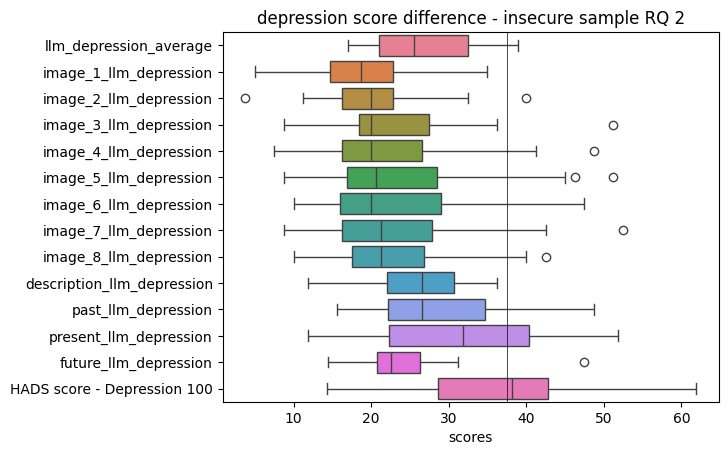

In [82]:
# Do the boxplot only for depression
# Do the boxplot only for depression
depression_columns = [
    col
    for col in df.columns
    if ("depression" in col and "llm" in col and col != "llm_depression")
    or col == "HADS score - Depression 100"
]

depression_df = df[[col for col in df.columns if col in depression_columns]]

depression_df_female = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("Demographic - Gender") == "female"
    ]
)

depression_df_male = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("Demographic - Gender") == "male"
    ]
)

depression_df_rq_1_secure = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ_result_style") == "Secure"
    ]
)

depression_df_rq_1_insecure = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ_result_style") != "Secure"
    ]
)

depression__df_rq_2_secure = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ2_style") == "secure"
    ]
)

depression_df_rq_2_insecure = df.from_dict(
    [
        {column: answer.get(column) for column in depression_columns}
        for answer in df.to_dict(orient="records")
        if answer.get("RQ2_style") == "insecure"
    ]
)


depression_dfs_dict = [
    {"data": depression_df, "title": "depression score difference - full sample"},
    {"data": depression_df_female, "title": "depression score difference - female sample"},
    {"data": depression_df_male, "title": "depression score difference - male sample"},
    {"data": depression_df_rq_1_secure, "title": "depression score difference - secure sample RQ 1"},
    {"data": depression_df_rq_1_insecure, "title": "depression score difference - insecure sample RQ 1"},
    {"data": depression__df_rq_2_secure, "title": "depression score difference - secure sample RQ 2"},
    {"data": depression_df_rq_2_insecure, "title": "depression score difference - insecure sample RQ 2"},
]


for depression_data in depression_dfs_dict:
    # Get the mean for HADS depression
    mean_depression = depression_data.get("data")["HADS score - Depression 100"].mean()
    print(depression_data.get("data").describe())
    # graph the distances for each image
    graph = sns.boxplot(
        data=depression_data.get("data"),
        orient="h",
        gap=0.01,
    )
    graph.axvline(mean_depression, color="black", linewidth=0.5)
    graph.set_title(depression_data.get("title"))
    graph.set_xlabel("scores")
    plt.show()

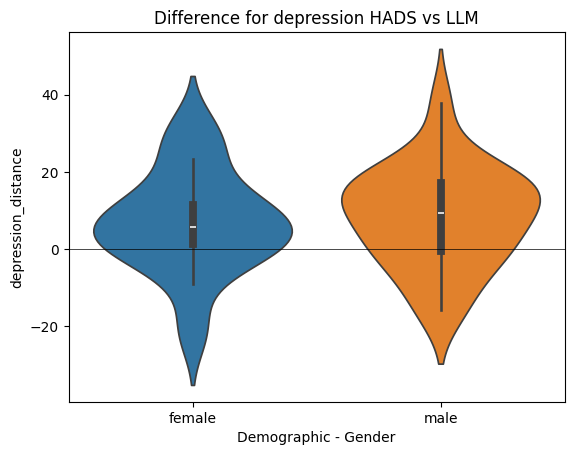

In [83]:
graph = sns.violinplot(
    data=df,
    hue="Demographic - Gender",
    y="depression_distance",
    x="Demographic - Gender",
    inner="box"
)
graph.set_title("Difference for depression HADS vs LLM")
graph.axhline(0, color="black", linewidth=0.5)

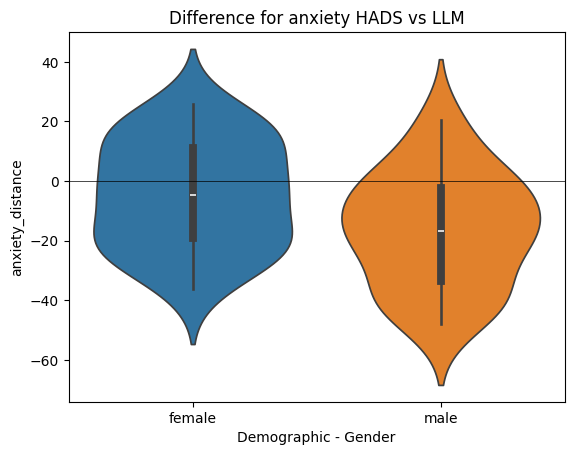

In [84]:
graph = sns.violinplot(
    data=df,
    hue="Demographic - Gender",
    y="anxiety_distance",
    x="Demographic - Gender",
    inner="box"
)
graph.set_title("Difference for anxiety HADS vs LLM")
graph.axhline(0, color="black", linewidth=0.5)

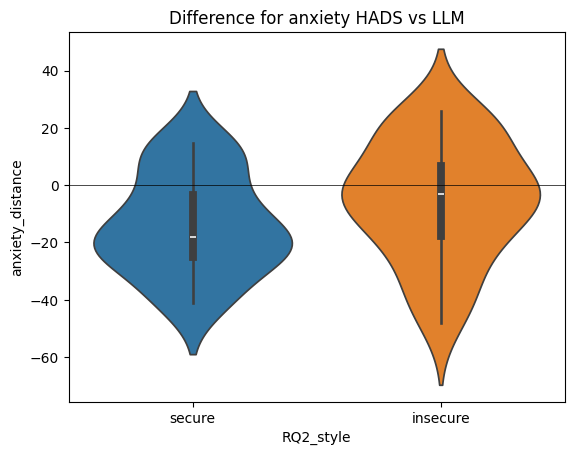

In [85]:
graph = sns.violinplot(
    data=df,
    hue="RQ2_style",
    y="anxiety_distance",
    x="RQ2_style",
    inner="box"
)
graph.set_title("Difference for anxiety HADS vs LLM")
graph.axhline(0, color="black", linewidth=0.5)

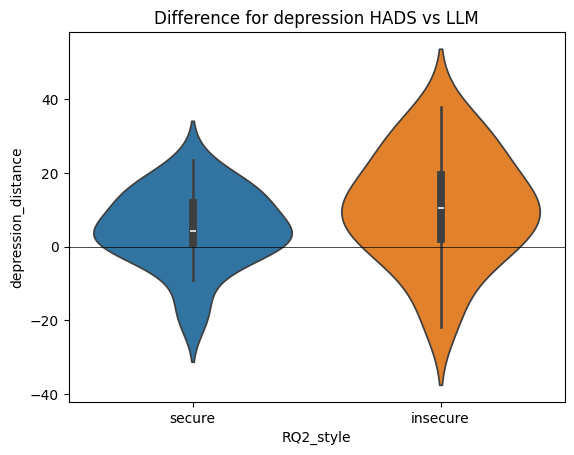

In [86]:
graph = sns.violinplot(
    data=df,
    hue="RQ2_style",
    y="depression_distance",
    x="RQ2_style",
    inner="box"
)
graph.set_title("Difference for depression HADS vs LLM")
graph.axhline(0, color="black", linewidth=0.5)

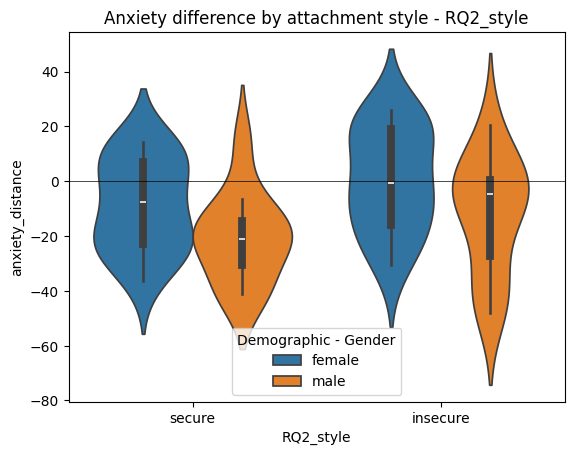

/tmp/ipykernel_2556/466797360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_style[style_name] = data_style[style_name].apply(


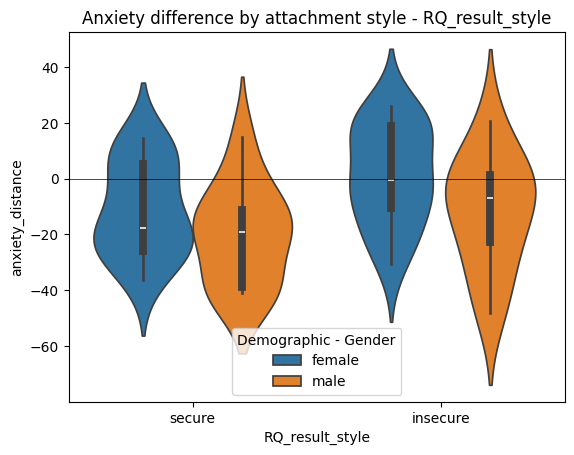

In [87]:
for style_name in ["RQ2_style", "RQ_result_style"]:
    data_style = df[[style_name, "Demographic - Gender", "anxiety_distance"]]
    if style_name == "RQ_result_style":
        # replace the value for "secure" or "insecure"
        data_style[style_name] = data_style[style_name].apply(
            lambda x: "secure" if x == "Secure" else "insecure"
        )

    graph = sns.violinplot(
        data=data_style,
        hue="Demographic - Gender",
        y="anxiety_distance",
        x=style_name,
        inner="box"
    )
    graph.set_title(f"Anxiety difference by attachment style - {style_name}")
    graph.axhline(0, color="black", linewidth=0.5)
    plt.show()

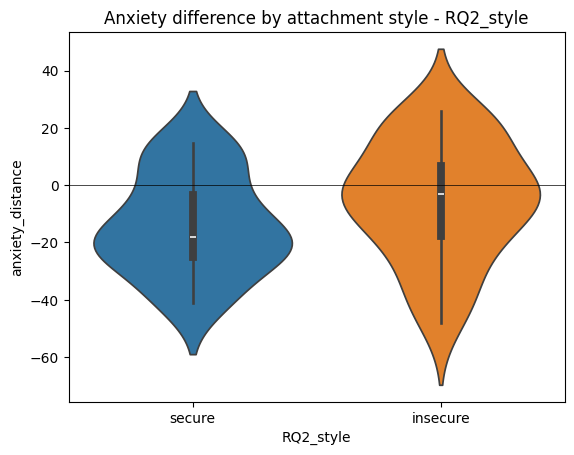

/tmp/ipykernel_2556/1985985427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_style[style_name] = data_style[style_name].apply(


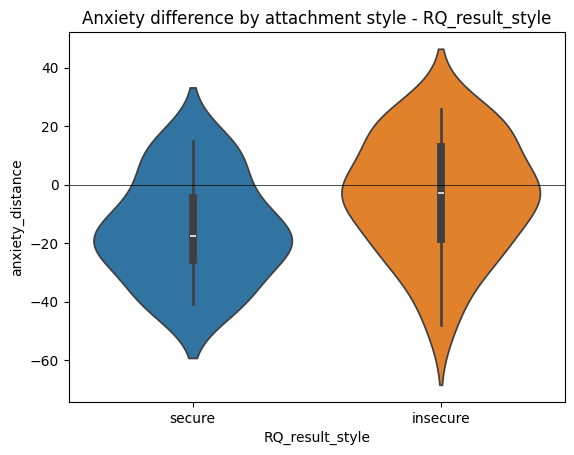

In [88]:
for style_name in ["RQ2_style", "RQ_result_style"]:
    data_style = df[[style_name, "Demographic - Gender", "anxiety_distance"]]
    if style_name == "RQ_result_style":
        # replace the value for "secure" or "insecure"
        data_style[style_name] = data_style[style_name].apply(
            lambda x: "secure" if x == "Secure" else "insecure"
        )

    graph = sns.violinplot(
        data=data_style,
        hue=style_name,
        y="anxiety_distance",
        x=style_name,
        inner="box"
    )
    graph.set_title(f"Anxiety difference by attachment style - {style_name}")
    graph.axhline(0, color="black", linewidth=0.5)
    plt.show()

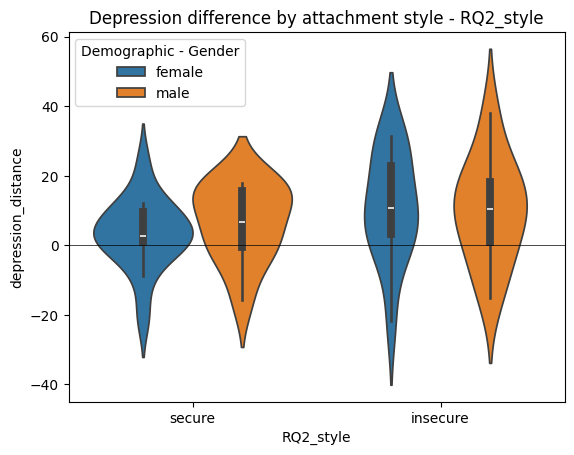

/tmp/ipykernel_2556/1107477437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_style[style_name] = data_style[style_name].apply(


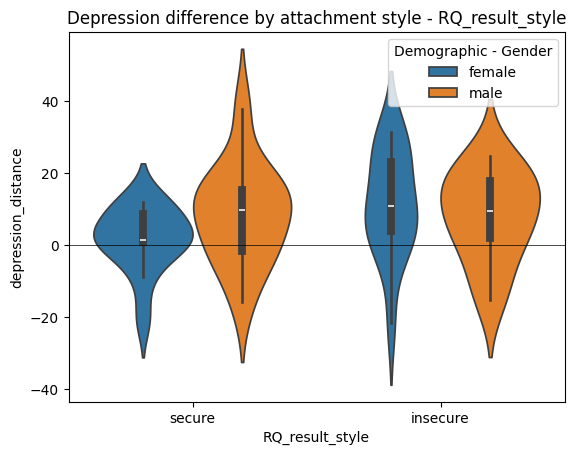

In [89]:
for style_name in ["RQ2_style", "RQ_result_style"]:
    data_style = df[[style_name, "Demographic - Gender", "depression_distance"]]
    if style_name == "RQ_result_style":
        # replace the value for "secure" or "insecure"
        data_style[style_name] = data_style[style_name].apply(
            lambda x: "secure" if x == "Secure" else "insecure"
        )

    graph = sns.violinplot(
        data=data_style,
        hue="Demographic - Gender",
        y="depression_distance",
        x=style_name,
        inner="box"
    )
    graph.set_title(f"Depression difference by attachment style - {style_name}")
    graph.axhline(0, color="black", linewidth=0.5)
    plt.show()

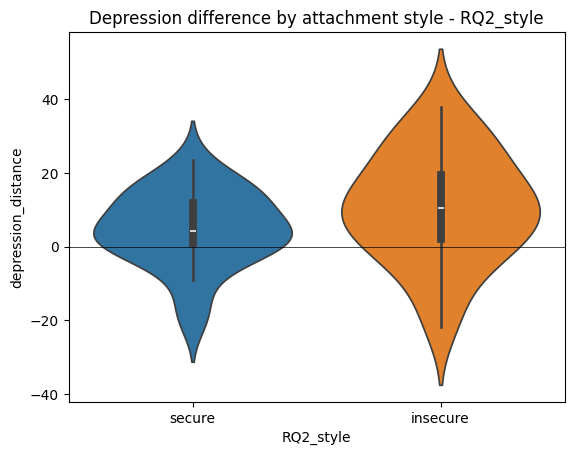

/tmp/ipykernel_2556/2490483328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_style[style_name] = data_style[style_name].apply(


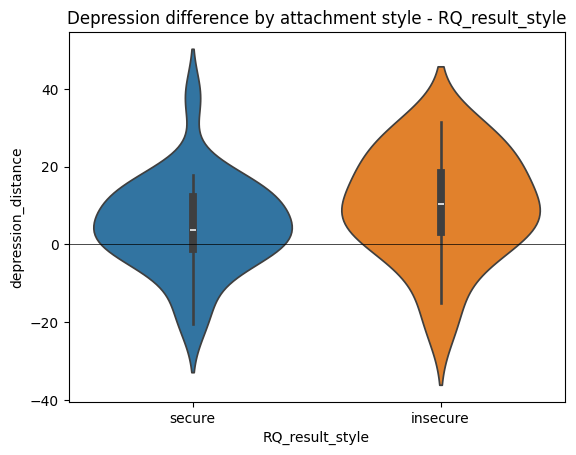

In [90]:
for style_name in ["RQ2_style", "RQ_result_style"]:
    data_style = df[[style_name, "Demographic - Gender", "depression_distance"]]
    if style_name == "RQ_result_style":
        # replace the value for "secure" or "insecure"
        data_style[style_name] = data_style[style_name].apply(
            lambda x: "secure" if x == "Secure" else "insecure"
        )

    graph = sns.violinplot(
        data=data_style,
        hue=style_name,
        y="depression_distance",
        x=style_name,
        inner="box"
    )
    graph.set_title(f"Depression difference by attachment style - {style_name}")
    graph.axhline(0, color="black", linewidth=0.5)
    plt.show()

In order to run a statistical test, we need to test normality for the results generated by the llm and the HADS survey

In [91]:
# test for normality for llm_depression_average and llm_anxiety_average, images and description, past, present and future
from scipy.stats import normaltest

col_to_test = [
    "llm_depression_average",
    "llm_anxiety_average",
    "HADS score - Depression 100",
    "HADS score - Anxiety 100",
]

for img_num in range(1, 9):
    col_to_test.append(f"image_{img_num}_llm_depression")
    col_to_test.append(f"image_{img_num}_llm_anxiety")

for time in ["description", "past", "present", "future"]:
    col_to_test.append(f"{time}_llm_depression")
    col_to_test.append(f"{time}_llm_anxiety")

normal_cols = []
non_normal_cols = []

for col in col_to_test:
    stat, p_value = normaltest(df[col])
    if p_value < 0.05:
        print(f"Column {col} is not normally distributed ({stat}, {p_value})")
        non_normal_cols.append(col)
    else:
        print(f"Column {col} is normally distributed ({stat}, {p_value})")
        normal_cols.append(col)

print(normal_cols)
print(non_normal_cols)

Column llm_depression_average is normally distributed (4.136668345165256, 0.12639616061871697)
Column llm_anxiety_average is normally distributed (2.1415197131945223, 0.3427479791322331)
Column HADS score - Depression 100 is normally distributed (1.0914506378261286, 0.5794213656147001)
Column HADS score - Anxiety 100 is not normally distributed (6.0520211749550015, 0.048508774131286146)
Column image_1_llm_depression is not normally distributed (12.9384482901839, 0.001550428173715203)
Column image_1_llm_anxiety is not normally distributed (17.76393999190457, 0.00013887032194279125)
Column image_2_llm_depression is normally distributed (3.278867097944787, 0.19408995361193424)
Column image_2_llm_anxiety is not normally distributed (7.067869807104815, 0.029189830423047163)
Column image_3_llm_depression is not normally distributed (14.972460105483723, 0.0005607529898272104)
Column image_3_llm_anxiety is not normally distributed (6.6115744823567555, 0.036670332074775235)
Column image_4_llm_d

Only the anxiety results from HADS are normal, therefore we will need to use a non-parametric test to check if the values are statistically different

In [92]:
from scipy.stats import wilcoxon, ttest_ind

# Do one way anova for the normal columns and HADS depression
depression_stats = []
for col in normal_cols:
    if "depression" in col and col != "HADS score - Depression 100":
        stat, p_value = ttest_ind(
            df[col].dropna(), df["HADS score - Depression 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        depression_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

# Use non-parametric Wilcoxon test for the non-normal columns
for col in non_normal_cols:
    if "depression" in col and col != "HADS score - Depression 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Depression 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        depression_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

depression_stats_df = pd.DataFrame(
    depression_stats,
    columns=["Data name", "Mean", "SD", "Statistic", "P-value", "Result"],
)
depression_stats_df.sort_values(by="Data name", inplace=True)
depression_stats_df

,Data name,Mean,SD,Statistic,P-value,Result
5,description_llm_depression,25.6125,7.112088,-4.378684,2.991609e-05,significant
12,future_llm_depression,23.0375,6.544113,158.000000,6.783549e-07,significant
8,image_1_llm_depression,18.7250,8.543444,82.000000,1.756897e-09,significant
1,image_2_llm_depression,19.6500,8.101083,-7.147328,1.591231e-10,significant
9,image_3_llm_depression,21.7000,9.209024,171.000000,1.547186e-06,significant
10,image_4_llm_depression,23.0250,11.313849,239.000000,6.206319e-05,significant
2,image_5_llm_depression,23.9750,11.239195,-4.415489,2.596970e-05,significant
3,image_6_llm_depression,23.2750,10.826466,-4.800433,5.680497e-06,significant
11,image_7_llm_depression,22.8500,9.936148,207.000000,1.228890e-05,significant
4,image_8_llm_depression,21.5250,8.904575,-6.029799,2.904813e-08,significant


In [93]:
# Anxiety is not normally distributed in HADS therefore we will use the Wilcoxon test only

anxiety_stats = []
for col in normal_cols:
    if "anxiety" in col and col != "HADS score - Anxiety 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Anxiety 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        anxiety_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

for col in non_normal_cols:
    if "anxiety" in col and col != "HADS score - Anxiety 100":
        stat, p_value = wilcoxon(
            df[col].dropna(), df["HADS score - Anxiety 100"].dropna()
        )
        is_significant = "significant" if p_value < 0.05 else "not significant"
        mean, std = df[col].mean(), df[col].std()
        anxiety_stats.append([f"{col}", mean, std, stat, p_value, is_significant])

anxiety_stats_df = pd.DataFrame(
    anxiety_stats, columns=["Data name", "Mean", "SD", "Statistic", "P-value", "Result"]
)
anxiety_stats_df.sort_values(by="Data name", inplace=True)
anxiety_stats_df

,Data name,Mean,SD,Statistic,P-value,Result
6,description_llm_anxiety,42.275,10.087911,404.5,0.024209,significant
12,future_llm_anxiety,38.900,10.701302,508.5,0.218662,not significant
9,image_1_llm_anxiety,30.650,14.921649,489.5,0.154303,not significant
10,image_2_llm_anxiety,33.450,15.376981,594.5,0.680645,not significant
11,image_3_llm_anxiety,37.350,14.253625,571.0,0.527279,not significant
1,image_4_llm_anxiety,40.100,16.019440,483.0,0.138073,not significant
2,image_5_llm_anxiety,41.600,16.176324,445.0,0.063466,not significant
3,image_6_llm_anxiety,39.700,14.512837,510.0,0.222315,not significant
4,image_7_llm_anxiety,39.100,14.345944,532.5,0.318325,not significant
5,image_8_llm_anxiety,38.500,12.586436,553.0,0.420723,not significant


This tells us that the data is statistically different, therefore the model is still not accurate for Style, Anxiety or Depression comparing against RQ and HADS.

Do a brief exploration around the Demographics of the excluded participants

In [94]:
# Use the excluded answers to show how many were excluded by what reasons
reasons = {"excluded_by_diagnosis": 0, "excluded_by_psychiatric": 0, "excluded_by_substances": 0, "excluded_by_diag_psych": 0, "excluded_by_diag_substances": 0, "excluded_by_psych_substances": 0, "excluded_by_all": 0}
for answer in excluded_answers:
    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - psychiatric disorder"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_all"] += 1
        continue

    if answer["Demographic - psychiatric disorder"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_psych_substances"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - psychiatric disorder"] == "yes":
        reasons["excluded_by_diag_psych"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes" and answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_diag_substances"] += 1
        continue

    if answer["Demographic - speech diagnosis"] == "yes":
        reasons["excluded_by_diagnosis"] += 1
        continue

    if answer["Demographic - psychiatric disorder"] == "yes":
        reasons["excluded_by_psychiatric"] += 1
        continue

    if answer["Demographic - Substances"] == "yes":
        reasons["excluded_by_substances"] += 1
        continue

print(reasons)


NameError: name 'excluded_answers' is not defined

In [ ]:
# check how many excluded come from prolific

excluded_from_prolific = len([answer for answer in excluded_answers if "PROLIFIC_PID" in answer.keys()])
print(excluded_from_prolific)

47


In [ ]:
# Get the mean and std for HADS scores by gender
df[["HADS score - Anxiety", "HADS score - Depression"]].groupby(df["Demographic - Gender"]).describe()

HADS score - Anxiety                                      \
                                    count      mean       std  min   25%  50%   
Demographic - Gender                                                            
female                               28.0  8.250000  3.728022  1.0  5.75  8.0   
male                                 22.0  6.090909  3.926820  0.0  4.00  5.5   

                                 HADS score - Depression                      \
                       75%   max                   count      mean       std   
Demographic - Gender                                                           
female                11.0  14.0                    28.0  7.035714  2.516349   
male                   8.0  15.0                    22.0  7.363636  2.517471   

                                                  
                      min   25%  50%   75%   max  
Demographic - Gender                              
female                2.0  6.00  7.0  8.25  12.0  
male                  3.0  5.25  7.0  9.00  13.0

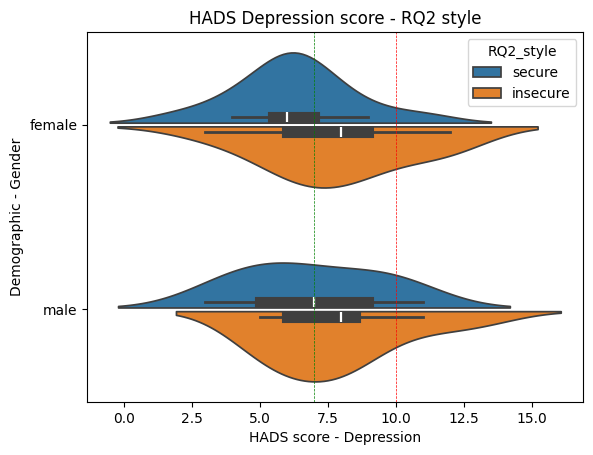

In [ ]:
# graph the HADS scores distribution by gender
graph = sns.violinplot(
    data=df,
    hue="RQ2_style",
    y="Demographic - Gender",
    x="HADS score - Depression",
    split=True,
    gap=0.05,
    inner_kws={"box_width": 8, "whis_width": 2, },
)

graph.set_title("HADS Depression score - RQ2 style")
graph.axvline(7, color="g", linestyle="--", linewidth=0.5)
graph.axvline(10, color="r", linestyle="--", linewidth=0.5)
plt.show()

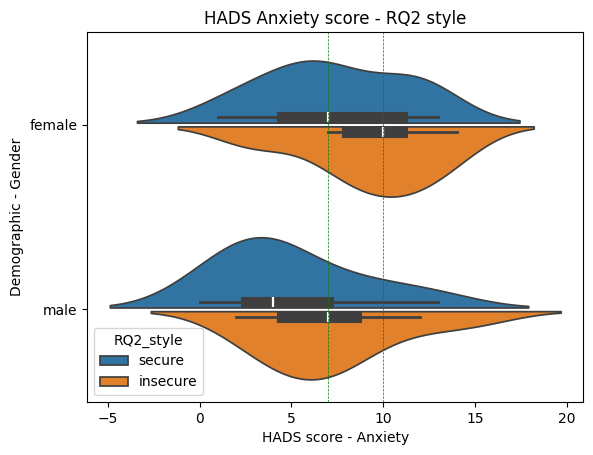

In [ ]:
# graph the HADS scores distribution by gender
graph = sns.violinplot(
    data=df,
    hue="RQ2_style",
    y="Demographic - Gender",
    x="HADS score - Anxiety",
    split=True,
    gap=0.05,
    inner_kws={"box_width": 8, "whis_width": 2, },
)

graph.set_title("HADS Anxiety score - RQ2 style")
graph.axvline(7, color="g", linestyle="--", linewidth=0.5)
graph.axvline(10, color="r", linestyle="--", linewidth=0.5)
plt.show()

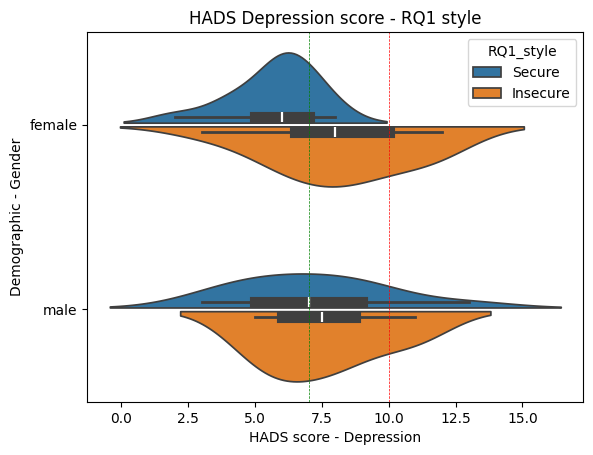

In [ ]:
# graph the HADS scores distribution by gender
graph = sns.violinplot(
    data=df,
    hue="RQ1_style",
    y="Demographic - Gender",
    x="HADS score - Depression",
    split=True,
    gap=0.05,
    inner_kws={"box_width": 8, "whis_width": 2, },
)

graph.set_title("HADS Depression score - RQ1 style")
graph.axvline(7, color="g", linestyle="--", linewidth=0.5)
graph.axvline(10, color="r", linestyle="--", linewidth=0.5)
plt.show()

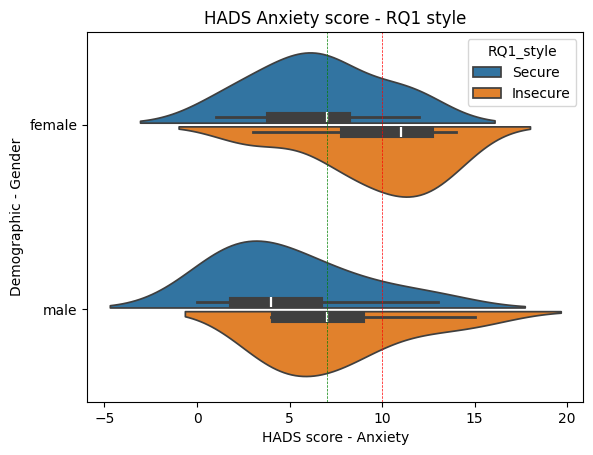

In [ ]:
# graph the HADS scores distribution by gender
graph = sns.violinplot(
    data=df,
    hue="RQ1_style",
    y="Demographic - Gender",
    x="HADS score - Anxiety",
    split=True,
    gap=0.05,
    inner_kws={"box_width": 8, "whis_width": 2, },
)

graph.set_title("HADS Anxiety score - RQ1 style")
graph.axvline(7, color="g", linestyle="--", linewidth=0.5)
graph.axvline(10, color="r", linestyle="--", linewidth=0.5)
plt.show()